In [ ]:
%load_ext autoreload
%autoreload 2

# Text: Core

> The `text.core` module contains the core bits required to use fast.ai's low-level and/or mid-level APIs to define `Datasets`, build `DataLoaders`, and train text/NLP models with fast.ai

In [ ]:
# |default_exp text.core
# |default_cls_lvl 3

In [ ]:
# |export
from __future__ import annotations

import gc, importlib, sys, traceback

from accelerate.logging import get_logger
from dataclasses import dataclass
from datasets import concatenate_datasets, load_dataset
from dotenv import load_dotenv
from fastai.callback.all import *
from fastai.imports import *
from fastai.learner import *
from fastai.losses import BaseLoss, BCEWithLogitsLossFlat, CrossEntropyLossFlat
from fastai.data.block import TransformBlock
from fastai.data.transforms import DataLoader, DataLoaders, Datasets, ColSplitter, ItemTransform, TfmdDL
from fastai.optimizer import Adam, OptimWrapper, params
from fastai.metrics import accuracy, F1Score, accuracy_multi, F1ScoreMulti
from fastai.test_utils import show_install
from fastai.torch_core import *
from fastai.torch_imports import *
from transformers import AutoConfig, AutoTokenizer, PretrainedConfig, PreTrainedTokenizerBase, PreTrainedModel
from transformers import AutoModelForSequenceClassification
from transformers import logging as hf_logging
from transformers.data.data_collator import DataCollatorWithPadding

from blurr.utils import clean_memory, get_hf_objects, set_seed, PreCalculatedLoss

In [ ]:
# |hide
import pdb

from datasets import Value
from fastai.data.block import MultiCategoryBlock, CategoryBlock, ColReader, ColSplitter, DataBlock, ItemGetter, RandomSplitter, FuncSplitter
from fastai.text.data import SortedDL
from fastcore.test import *
import nbdev

from blurr.utils import print_versions, PreCalculatedCrossEntropyLoss, PreCalculatedBCELoss, PreCalculatedMSELoss

In [ ]:
# |export
# silence all the HF warnings and load environment variables
warnings.simplefilter("ignore")
hf_logging.set_verbosity_error()
logger = get_logger(__name__)

load_dotenv()

False

In [ ]:
# |hide
# |notest
torch.cuda.set_device(0)
print(f"Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}")

Using GPU #0: NVIDIA GeForce RTX 3090


In [ ]:
# | echo: false
os.environ["TOKENIZERS_PARALLELISM"] = "false"
print("What we're running with at the time this documentation was generated:")
print_versions("torch fastai transformers")

What we're running with at the time this documentation was generated:
torch: 1.13.1
fastai: 2.7.11
transformers: 4.26.1


## Setup

We'll use a subset of `imdb` to demonstrate how to configure your BLURR for sequence classification tasks. **BLURR** is designed to work with Hugging Face `Dataset` and/or pandas `DataFrame` objects

In [ ]:
def get_new_hf_objects(labels):
    model_cls = AutoModelForSequenceClassification
    hf_logging.set_verbosity_error()

    pretrained_model_name = "microsoft/deberta-v3-small"
    n_labels = len(labels)

    hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(
        pretrained_model_name, model_cls=model_cls, config_kwargs={"num_labels": n_labels}
    )

    hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

    print("=== config ===")
    print(f"# of labels:\t{hf_config.num_labels}")
    print("")
    print("=== tokenizer ===")
    print(f"Vocab size:\t\t{hf_tokenizer.vocab_size}")
    print(f"Max # of tokens:\t{hf_tokenizer.model_max_length}")
    print(f"Attributes expected by model in forward pass:\t{hf_tokenizer.model_input_names}")

    return hf_arch, hf_config, hf_tokenizer, hf_model

### Multiclass

In [ ]:
imdb_dsd = load_dataset("imdb", split=["train", "test"])

# build HF `Dataset` objects
train_ds = imdb_dsd[0].add_column("is_valid", [False] * len(imdb_dsd[0])).shuffle().select(range(1000))
valid_ds = imdb_dsd[1].add_column("is_valid", [True] * len(imdb_dsd[1])).shuffle().select(range(200))
imdb_ds = concatenate_datasets([train_ds, valid_ds])

# build a `DataFrame` representation as well
imdb_df = pd.DataFrame(imdb_ds)

print(len(train_ds), len(valid_ds))
print(len(imdb_df[imdb_df["is_valid"] == False]), len(imdb_df[imdb_df["is_valid"] == True]))
imdb_df.head()

Found cached dataset imdb (/home/wgilliam/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/2 [00:00<?, ?it/s]

1000 200
1000 200


,text,label,is_valid
0,"What kind of a documentary about a musician fails to include a single track by the artist himself?! Unlike ""Ray"" or countless other films about music artists, half the fun in the theater (or on the couch) is reliving the great songs themselves. Here, all the tracks are covers put on by uninteresting characters, and these renditions fail to capture Cohen's slow, jazzy style. More often, the covers are badly sung folk versions. Yuck.<br /><br />The interviews are as much or more with other musicians and figures rather than with Cohen himself. Only rarely does the film feature Cohen reading h...",0,False
1,"Having not seen the previous two in the trilogy of Bourne movies, I was a little reluctant to watch The Bourne Ultimatum.<br /><br />However it was a very thrilling experience and I didn't have the problem of not understanding what was happening due to not seeing the first two films. Each part of the story was easy to understand and I fell in love with The Bourne Ultimatum before it had reached the interval! I don't think I have ever watched such an exquisitely made, and gripping film, especially an action film. Since I usually shy away from action and thriller type movies, this was such g...",1,False
2,"As romantic comedies go, this was a cute and winning one. I thought that the writing could have been stronger to build up the final connection a bit better, but that is not a huge tripping point. But, Amanda Detmer and Scott Wolf give nice performances and are as charming as ever. These are two of my favorite actors, and I was just glad to see them cast as romantic leads. I hope to see them cast in more projects soon.<br /><br />Overall, this movie won't change your life, but is is sweet, warm and winning. Not a bad thing to be at all.",1,False
3,"Nick Cage is Randall Raines, a retired car thief who is forced out of retirement when he's forced to save his the life of his brother Kip (Giovanni Ribisi) when he screws up on a job, by completing his brothers job of stealing 50 cars in one night. He has to get together his old crew that he can trust to help him pull it off and get his bro out of dutch. But the cops are onto him, so can he pull it off? This was one of the great candidates of a film to re-make as the Original was far from a classic. And if you don't go into it expecting much, and turn the thinking portion of your brain off...",1,False
4,"This group of English pros are a pleasure to watch. The supporting cast could form a series of their own. It's a seen before love tiangle between the head of surgery, his wife, and a new pretty boy surgery resident. Only the superior acting skills of Francesca Annis, Michael Kitchen, and the sexy Robson Greene lift this from the trash category to a very enjoyable ""romp"". The only quibble is that it's hard to accept that the smoldering Francesca Annis would fall in love and actually marry Michael Kitchen, who like me, is hardly an international, or even a British sex symbol. You can readily...",1,False


In [ ]:
labels = imdb_dsd[0].features["label"].names
labels

['neg', 'pos']

### Multilabel

In [ ]:
civil_dsd = load_dataset("civil_comments", split=["train", "validation"])

# round the floats
civil_labels = ["toxicity", "severe_toxicity", "obscene", "threat", "insult", "identity_attack", "sexual_explicit"]


def round_targs(example):
    for lbl in civil_labels:
        example[lbl] = np.round(example[lbl])
    return example


# convert floats to ints
def fix_dtypes(ds):
    new_features = ds.features.copy()
    for lbl in civil_labels:
        new_features[lbl] = Value("int32")
    return ds.cast(new_features)


# build HF `Dataset` objects
civil_train_ds = civil_dsd[0].add_column("is_valid", [False] * len(civil_dsd[0])).shuffle().select(range(1000))
civil_train_ds = civil_train_ds.map(round_targs)
civil_train_ds = fix_dtypes(civil_train_ds)

civil_valid_ds = civil_dsd[1].add_column("is_valid", [True] * len(civil_dsd[1])).shuffle().select(range(200))
civil_valid_ds = civil_valid_ds.map(round_targs)
civil_valid_ds = fix_dtypes(civil_valid_ds)

civil_ds = concatenate_datasets([civil_train_ds, civil_valid_ds])

# build a `DataFrame` representation as well
civil_df = pd.DataFrame(civil_ds)

print(len(civil_train_ds), len(civil_valid_ds))
print(len(civil_df[civil_df["is_valid"] == False]), len(civil_df[civil_df["is_valid"] == True]))
civil_df.head()

Found cached dataset civil_comments (/home/wgilliam/.cache/huggingface/datasets/civil_comments/default/0.9.0/e7a3aacd2ab7d135fa958e7209d10b1fa03807d44c486e3c34897aa08ea8ffab)


  0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/200 [00:00<?, ? examples/s]

1000 200
1000 200


,text,toxicity,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit,is_valid
0,"That was a GREAT JOB!!\n\nAnd, alot of work too. The guy doing the rowing sure got his workout for the day.\n\nI would agree with the comments here that it would be a hunter first and foremost that would take so much trouble and care for a rescue such as this.\n\nI had to chuckle after they turned the moose loose the first time the guy (ranger?) says ""Can we get back up on him?"" If I'm the guy rowing I would have said; ""What do you mean WE? Got a mouse in your pocket?"".",0,0,0,0,0,0,0,False
1,"I submit that we don't know what those marches might have impacted, behind closed Washington doors, or what they might have inspired in others, or what might be different if those marches had never happened.",0,0,0,0,0,0,0,False
2,"Which likely occurred. Her constant refusal to allow the employee to do their job is what escalated the issue. There comes a point where politeness and civility is trumped by safety, regulations and procedure. An unsecured stroller will do a lot of damage in the event of turbulence or emergency deplaning.",0,0,0,0,0,0,0,False
3,A drug enforcement thug missing his rice bowl.,0,0,0,0,0,0,0,False
4,"I am all for the fair and human treatment of animals, but does it not seem odd that a human fetus that has a more highly evolved level of intelligence, both emotional and rational has even less rights than animals or even certain plant life... Just sayin...",0,0,0,0,0,0,0,False


## Core: Data

A base collation function that works with a variety of input formats and pads inputs on-the-fly at batch time

### `TextCollatorWithPadding` -

In [ ]:
# |export
@dataclass
class TextCollatorWithPadding:
    def __init__(
        self,
        # A Hugging Face tokenizer
        hf_tokenizer: PreTrainedTokenizerBase,
        # The abbreviation/name of your Hugging Face transformer architecture (e.b., bert, bart, etc..)
        hf_arch: str = None,
        # A specific configuration instance you want to use
        hf_config: PretrainedConfig = None,
        # A Hugging Face model
        hf_model: PreTrainedModel = None,
        # The number of inputs expected by your model
        n_inp: int = 1,
        # Defaults to use Hugging Face's DataCollatorWithPadding(tokenizer=hf_tokenizer)
        data_collator_cls: type = DataCollatorWithPadding,
        # kwyargs specific for the instantiation of the `data_collator`
        data_collator_kwargs: dict = {},
    ):
        store_attr()
        self.hf_tokenizer = data_collator_kwargs.pop("tokenizer", self.hf_tokenizer)
        self.data_collator = data_collator_cls(tokenizer=self.hf_tokenizer, **data_collator_kwargs)

    def __call__(self, features):
        features = L(features)
        inputs, labels, targs = [], [], []

        # features contain dictionaries
        if isinstance(features[0], dict):
            feature_keys = list(features[0].keys())
            inputs = [self._build_inputs_d(features, feature_keys)]

            input_labels = self._build_input_labels(features, feature_keys)
            if input_labels is not None:
                labels, targs = [input_labels], [input_labels.clone()]
        # features contains tuples, each of which can contain multiple inputs and/or targets
        elif isinstance(features[0], tuple):
            for f_idx in range(self.n_inp):
                feature_keys = list(features[0][f_idx].keys())
                inputs.append(self._build_inputs_d(features.itemgot(f_idx), feature_keys))

                input_labels = self._build_input_labels(features.itemgot(f_idx), feature_keys)
                labels.append(input_labels if input_labels is not None else [])

            targs = [self._proc_targets(list(features.itemgot(f_idx))) for f_idx in range(self.n_inp, len(features[0]))]

        return self._build_batch(inputs, labels, targs)

    # ----- utility methods -----

    # to build the inputs dictionary
    def _build_inputs_d(self, features, feature_keys):
        return {fwd_arg: list(features.attrgot(fwd_arg)) for fwd_arg in self.hf_tokenizer.model_input_names if fwd_arg in feature_keys}

    # to build the input "labels"
    def _build_input_labels(self, features, feature_keys):
        if "label" in feature_keys:
            labels = list(features.attrgot("label"))
            return self._proc_targets(labels)
        return None

    # used to give the labels/targets the right shape
    def _proc_targets(self, targs):
        if is_listy(targs[0]):
            targs = torch.stack([tensor(lbls) for lbls in targs])
        elif isinstance(targs[0], torch.Tensor) and len(targs[0].size()) > 0:
            targs = torch.stack(targs)
        else:
            targs = torch.tensor(targs)

        return targs

    # will properly assemble are batch given a list of inputs, labels, and targets
    def _build_batch(self, inputs, labels, targs):
        batch = []

        for input, input_labels in zip(inputs, labels):
            input_d = dict(self.data_collator(input))
            if len(input_labels) > 0:
                input_d["labels"] = input_labels
            batch.append(input_d)

        for targ in targs:
            batch.append(targ)

        return tuplify(batch)

## Core: Training

Base plitters for defining paramater groups, model wrapper, and model callback

### `blurr_splitter`s -

In [ ]:
# |export
def blurr_params(modules: Module | list[Module]):
    "Like fast.ai's `params()` method, this method returns all parameters of `m` but also works with lists of modules"
    if not is_listy(modules):
        modules = [modules]
    return [p for m in modules for p in m.parameters()]

In [ ]:
nbdev.show_doc(blurr_params, title_level=3)

---

[source](https://github.com/ohmeow/blurr/blob/dev-3.0.0 #master/blurr/text/core.py#L132){target="_blank" style="float:right; font-size:smaller"}

### blurr_params

>      blurr_params
>                    (modules:fastai.torch_core.Module|list[fastai.torch_core.Mo
>                    dule])

Like fast.ai's `params()` method, this method returns all parameters of `m` but also works with lists of modules

In [ ]:
# |export
def blurr_splitter(m: Module):
    """Splits the Hugging Face model based on various model architecture conventions"""
    model = m.hf_model if (hasattr(m, "hf_model")) else m
    root_modules = list(model.named_children())
    top_module_name, top_module = root_modules[0]

    groups = L([m for m_name, m in list(top_module.named_children())])
    groups += L([m for m_name, m in root_modules[1:]])

    return groups.map(params).filter(lambda el: len(el) > 0)

In [ ]:
nbdev.show_doc(blurr_splitter, title_level=3)

---

[source](https://github.com/ohmeow/blurr/blob/dev-3.0.0 #master/blurr/text/core.py#L139){target="_blank" style="float:right; font-size:smaller"}

### blurr_splitter

>      blurr_splitter (m:fastai.torch_core.Module)

Splits the Hugging Face model based on various model architecture conventions

In [ ]:
# |export
def blurr_splitter_on_head(m: Module):
    """Creates two layers groups: One for the backbone and one for the pooler/classification head"""
    model = m.hf_model if (hasattr(m, "hf_model")) else m
    root_modules = list(model.named_children())
    backbone_module_name, backbone_module = root_modules[0]

    groups = L(backbone_module)
    groups.append(L([m for m_name, m in root_modules[1:]]))

    return groups.map(blurr_params).filter(lambda el: len(el) > 0)

In [ ]:
nbdev.show_doc(blurr_splitter_on_head, title_level=3)

---

[source](https://github.com/ohmeow/blurr/blob/dev-3.0.0 #master/blurr/text/core.py#L151){target="_blank" style="float:right; font-size:smaller"}

### blurr_splitter_on_head

>      blurr_splitter_on_head (m:fastai.torch_core.Module)

Creates two layers groups: One for the backbone and one for the pooler/classification head

### `BaseModelWrapper` -

In [ ]:
# |export
class BaseModelWrapper(Module):
    def __init__(
        self,
        # Your Hugging Face model
        hf_model: PreTrainedModel,
        # If True, hidden_states will be returned and accessed from Learner
        output_hidden_states: bool = False,
        # If True, attentions will be returned and accessed from Learner
        output_attentions: bool = False,
        # Any additional keyword arguments you want passed into your models forward method
        hf_model_kwargs={},
    ):
        super().__init__()

        store_attr()
        self.hf_model = hf_model.cuda() if torch.cuda.is_available() else hf_model
        self.hf_model_fwd_args = list(inspect.signature(self.hf_model.forward).parameters.keys())

    def forward(self, x):
        for k in list(x):
            if k not in self.hf_model_fwd_args:
                del x[k]

        return self.hf_model(
            **x,
            output_hidden_states=self.output_hidden_states,
            output_attentions=self.output_attentions,
            return_dict=True,
            **self.hf_model_kwargs,
        )

Note that `BaseModelWrapper` includes some nifty code for just passing in the things your model needs, as not all transformer architectures require/use the same information.

### `BaseModelCallback` -

In [ ]:
# |export
class BaseModelCallback(Callback):
    def __init__(
        self,
        # Additional keyword arguments passed to `BaseModelWrapper`
        base_model_wrapper_kwargs: dict = {},
    ):
        self.base_model_wrapper_kwargs = base_model_wrapper_kwargs

    def after_create(self):
        if isinstance(self.learn.model, PreTrainedModel):
            self.learn.model = BaseModelWrapper(self.learn.model, **self.base_model_wrapper_kwargs)

    def before_batch(self):
        self.hf_loss = None

    def after_pred(self):
        model_outputs = self.pred
        self.learn.blurr_model_outputs = {}

        for k, v in model_outputs.items():
            # if the "labels" are included, we are training with target labels in which case the loss is returned
            if k == "loss" and isinstance(self.learn.loss_func, PreCalculatedLoss):
                self.hf_loss = to_float(v)
            # the logits represent the prediction
            elif k == "logits":
                self.learn.pred = v
            # add any other things included in model_outputs as blurr_{model_output_key}
            else:
                self.learn.blurr_model_outputs[k] = v

    def after_loss(self):
        # if we already have the loss from the model, update the Learner's loss to be it
        if self.hf_loss is not None:
            self.learn.loss_grad = self.hf_loss
            self.learn.loss = self.learn.loss_grad.clone()

We use a `Callback` for handling the [`ModelOutput`](https://huggingface.co/transformers/main_classes/output.html#transformers.file_utils.ModelOutput) returned by Hugging Face transformers. It allows us to associate anything we want from that object to our `Learner`.

**Note** that your `Learner`'s loss will be set for you only if the Hugging Face model returns one *and* you are using the `PreCalculatedLoss` loss function.  

Also note that anything else you asked the model to return (for example, last hidden state, etc..) will be available for you via the `blurr_model_outputs` property attached to your `Learner`. For example, assuming you are using BERT for a classification task ... if you have told your `BaseModelWrapper` instance to return attentions, you'd be able to access them via `learn.blurr_model_outputs['attentions']`.

## Core: Examples

This section demonstrates how you can use standard `Dataset` objects (PyTorch and Hugging Face) to build PyTorch `DataLoader` iterators and train your model using the fast.ai `Learner`. 

**Note** that most fast.ai specific features such as `DataLoaders.one_batch`, `Learner.show_summary`, `DataLoader.show_batch`, `Learner.show_results` are not available when using PyTorch.

### PyTorch

#### Multiclass

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_new_hf_objects(labels)

=== config ===
# of labels:	2

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `torch.utils.data.Dataset`s

In [ ]:
print("Train|Validation examples: ", len(train_ds), len(valid_ds))

print(train_ds[:2])
print("")
print(train_ds["text"][:2])

Train|Validation examples:  1000 200
{'text': ['What kind of a documentary about a musician fails to include a single track by the artist himself?! Unlike "Ray" or countless other films about music artists, half the fun in the theater (or on the couch) is reliving the great songs themselves. Here, all the tracks are covers put on by uninteresting characters, and these renditions fail to capture Cohen\'s slow, jazzy style. More often, the covers are badly sung folk versions. Yuck.<br /><br />The interviews are as much or more with other musicians and figures rather than with Cohen himself. Only rarely does the film feature Cohen reading his own work (never singing)-- like letters, poems, etc. The movie really didn\'t capture much about the artist\'s life story, either, or about his development through the years. A huge disappointment for a big Cohen fan.', "Having not seen the previous two in the trilogy of Bourne movies, I was a little reluctant to watch The Bourne Ultimatum.<br /><br 

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    return hf_tokenizer(example["text"], truncation=True)


proc_train_ds = train_ds.map(tokenize_func, batched=True)
proc_train_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

proc_valid_ds = valid_ds.map(tokenize_func, batched=True)
proc_valid_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
# define our PyTorch Dataset class
class HFTextClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, hf_tokenizer):
        self.hf_dataset = hf_dataset
        self.hf_tokenizer = hf_tokenizer

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        item = self.hf_dataset[idx]
        return item


# build our PyTorch training and validation Datasets
pt_proc_train_ds = HFTextClassificationDataset(proc_train_ds, hf_tokenizer=hf_tokenizer)
pt_proc_valid_ds = HFTextClassificationDataset(proc_valid_ds, hf_tokenizer=hf_tokenizer)

##### Step 3: `DataLoaders`

In [ ]:
# build your fastai `DataLoaders` from Pytorch `DataLoader` objects
batch_size = 4
data_collator = TextCollatorWithPadding(hf_tokenizer)
train_dl = torch.utils.data.DataLoader(pt_proc_train_ds, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
valid_dl = torch.utils.data.DataLoader(pt_proc_valid_ds, batch_size=batch_size * 2, shuffle=False, collate_fn=data_collator)

dls = DataLoaders(train_dl, valid_dl)

In [ ]:
print(len(train_dl), len(valid_dl))

b = next(iter(train_dl))
print(len(b))
print("")
print(hf_tokenizer.decode(b[0]["input_ids"][0][:200]))
print("")
print(b[1])

# b

250 25
2

[CLS] Thin story concerns two small town brothers and their struggles over family honor. David Morse is the responsible, straight-laced cop and 'good' brother; Viggo Mortensen, the 'bad' boy, is a former soldier and ex-convict. As an actor (particularly in his earliest years), Sean Penn seems to have modulated his performances under the Method. Turning first-time writer and director for this arty, obtuse drama, he works his script and characters out through the same methodical process, slowing the pacing down to a crawl (ostensibly so we can catch every nuance and inflection). This approach might be fascinating if there were three-dimensional characters to care about, but photogenic Morse and Mortensen aren't really convincing as siblings. Worse, we expect more from prominently-billed veterans Charles Bronson and Sandy Dennis, who hardly get a chance to come through with anything interesting. The picture is balky with turgid sequences, a wobbly narrative and confusing editing

In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'show_batch'
# dls.show_batch(dataloaders=dls, max_n=2, trunc_at=800)

##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=PreCalculatedCrossEntropyLoss(),  # CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'show_batch'
# learn.dls.valid.show_batch(dataloaders=dls, max_n=2, trunc_at=800)

In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'one_batch'
# learn.summary()

##### Step 5: Train

SuggestedLRs(minimum=2.7542287170945203e-07, steep=0.0008317637839354575, valley=0.0003981071640737355, slide=0.0006918309954926372)

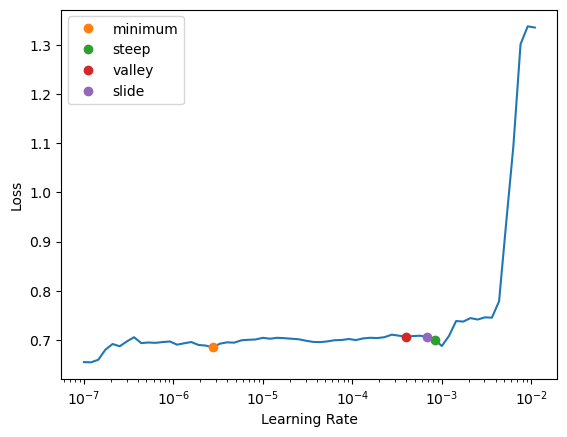

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.690314,0.658165,0.765000,00:22
1,0.215387,0.138888,0.950000,00:23
2,0.137903,0.145928,0.950000,00:22


In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.1379033327102661
valid_loss 0.1459275186061859
accuracy 0.949999988079071


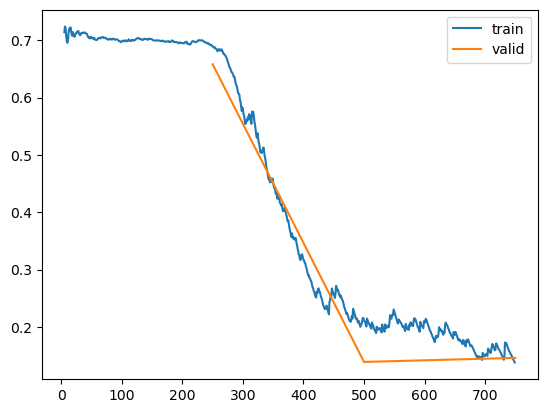

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.show_results(learner=learn, max_n=2, trunc_at=500)

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.export("../models/test.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

#### Multilabel

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_new_hf_objects(civil_labels)

=== config ===
# of labels:	7

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `torch.utils.data.Dataset`s

In [ ]:
print("Train|Validation examples: ", len(civil_train_ds), len(civil_valid_ds))

print(civil_train_ds[:2])
print("")
print(civil_train_ds["text"][:2])

Train|Validation examples:  1000 200
{'text': ['That was a GREAT JOB!!\n\nAnd, alot of work too.  The guy doing the rowing sure got his workout for the day.\n\nI would agree with the comments here that it would be a hunter first and foremost that would take so much trouble and care for a rescue such as this.\n\nI had to chuckle after they turned the moose loose the first time the guy (ranger?) says "Can we get back up on him?"  If I\'m the guy rowing I would have said; "What do you mean WE?  Got a mouse in your pocket?".', "I submit that we don't know what those marches might have impacted, behind closed Washington doors, or what they might have inspired in others, or what might be different if those marches had never happened."], 'toxicity': [0, 0], 'severe_toxicity': [0, 0], 'obscene': [0, 0], 'threat': [0, 0], 'insult': [0, 0], 'identity_attack': [0, 0], 'sexual_explicit': [0, 0], 'is_valid': [False, False]}

['That was a GREAT JOB!!\n\nAnd, alot of work too.  The guy doing the rowi

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    return hf_tokenizer(example["text"], truncation=True)


proc_civil_train_ds = civil_train_ds.map(tokenize_func, batched=True)
proc_civil_train_ds.set_format("torch", columns=hf_tokenizer.model_input_names + civil_labels)

proc_civil_valid_ds = civil_valid_ds.map(tokenize_func, batched=True)
proc_civil_valid_ds.set_format("torch", columns=hf_tokenizer.model_input_names + civil_labels)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
# define our PyTorch Dataset class
class HFTextMultilabelClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, hf_tokenizer, labels):
        self.hf_dataset = hf_dataset
        self.hf_tokenizer = hf_tokenizer
        self.labels = labels

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        item = self.hf_dataset[idx]
        item["label"] = [item[lbl] for lbl in self.labels]
        return item


# build our PyTorch training and validation Datasets
pt_proc_civil_train_ds = HFTextMultilabelClassificationDataset(proc_civil_train_ds, hf_tokenizer=hf_tokenizer, labels=civil_labels)
pt_proc_civil_valid_ds = HFTextMultilabelClassificationDataset(proc_civil_valid_ds, hf_tokenizer=hf_tokenizer, labels=civil_labels)

##### Step 3: `DataLoaders`

In [ ]:
# build your fastai `DataLoaders` from Pytorch `DataLoader` objects
batch_size = 4
data_collator = TextCollatorWithPadding(hf_tokenizer)
train_dl = torch.utils.data.DataLoader(pt_proc_civil_train_ds, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
valid_dl = torch.utils.data.DataLoader(pt_proc_civil_valid_ds, batch_size=batch_size * 2, shuffle=False, collate_fn=data_collator)

dls = DataLoaders(train_dl, valid_dl)

In [ ]:
print(len(train_dl), len(valid_dl))

b = next(iter(train_dl))
print(len(b))
print("")
print(hf_tokenizer.decode(b[0]["input_ids"][0][:200]))
print("")
print(b[1])

# b

250 25
2

[CLS] I hope they lower rates so I can continue to finance a life I can't afford[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]

tensor([[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]])


In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'show_batch'
# dls.show_batch(dataloaders=dls, max_n=2, trunc_at=800)

##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=BCEWithLogitsLossFlat(),
    metrics=[partial(accuracy_multi, thresh=0.2)],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.loss_func.thresh = 0.15
learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'show_batch'
# learn.dls.valid.show_batch()

In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'one_batch'
# learn.summary()

##### Step 5: Train

SuggestedLRs(minimum=0.0005248074419796466, steep=0.04786301031708717, valley=6.30957365501672e-05, slide=0.001737800776027143)

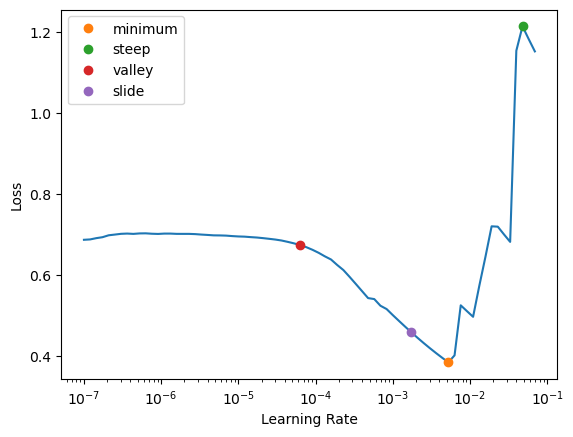

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.131406,0.080280,0.982857,00:14
1,0.072618,0.076288,0.982857,00:15
2,0.066920,0.075920,0.982857,00:15


In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.06691960990428925
valid_loss 0.07592008262872696
accuracy_multi 0.9828571081161499


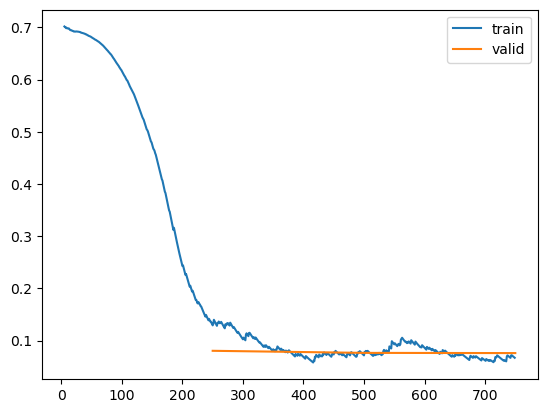

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.show_results(learner=learn, max_n=2, trunc_at=500)

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.export("../models/test.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

### Hugging Face

#### Multiclass

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_new_hf_objects(labels)

=== config ===
# of labels:	2

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `Datasets`

We'll use the Hugging Face `Dataset` objects created in *Setup*, but these could just as well be instances of `torch.utils.data.Dataset`

In [ ]:
print("Train|Validation examples: ", len(train_ds), len(valid_ds))

print(train_ds[:2])
print("")
print(train_ds["text"][:2])

Train|Validation examples:  1000 200
{'text': ['What kind of a documentary about a musician fails to include a single track by the artist himself?! Unlike "Ray" or countless other films about music artists, half the fun in the theater (or on the couch) is reliving the great songs themselves. Here, all the tracks are covers put on by uninteresting characters, and these renditions fail to capture Cohen\'s slow, jazzy style. More often, the covers are badly sung folk versions. Yuck.<br /><br />The interviews are as much or more with other musicians and figures rather than with Cohen himself. Only rarely does the film feature Cohen reading his own work (never singing)-- like letters, poems, etc. The movie really didn\'t capture much about the artist\'s life story, either, or about his development through the years. A huge disappointment for a big Cohen fan.', "Having not seen the previous two in the trilogy of Bourne movies, I was a little reluctant to watch The Bourne Ultimatum.<br /><br 

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    return hf_tokenizer(example["text"], truncation=True)


proc_train_ds = train_ds.map(tokenize_func, batched=True)
proc_train_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

proc_valid_ds = valid_ds.map(tokenize_func, batched=True)
proc_valid_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

print(proc_train_ds)
print(proc_valid_ds)

Loading cached processed dataset at /home/wgilliam/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-68abca3abfc373f6.arrow


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'is_valid', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1000
})
Dataset({
    features: ['text', 'label', 'is_valid', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 200
})


##### Step 3: `DataLoaders`

In [ ]:
# build your fastai `DataLoaders` from Pytorch `DataLoader` objects
batch_size = 4
data_collator = TextCollatorWithPadding(hf_tokenizer)
train_dl = torch.utils.data.DataLoader(proc_train_ds, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
valid_dl = torch.utils.data.DataLoader(proc_valid_ds, batch_size=batch_size * 2, shuffle=False, collate_fn=data_collator)

dls = DataLoaders(train_dl, valid_dl)

In [ ]:
print(len(train_dl), len(valid_dl))

b = next(iter(train_dl))
print(len(b))
print("")
print(hf_tokenizer.decode(b[0]["input_ids"][0][:200]))
print("")
print(b[1])

# b

250 25
2

[CLS] A sweet little movie which would not even offend your Grandmother, "Saving Grace" seems cut from the same cloth as a half-dozen other British comedies over the past two years...underdog is faced with adversity, finds the strength to challenge and learns something about him/herself in the process.<br /><br />Widowed and thus broke, Grace is a master gardener, and is enlisted to help her friend/employee Matthew grow his pot plant. He's been doing it all wrong, so Grace helps him out. They realize that she is the perfect person to harvest pot, which they can both benefit from. He enjoys smoking, she needs to raise funds to pay her mortgage. <br /><br />Highlight is Grace travelling to London to deal some of her merchandise, dressed in what looks like the white suit John Travolta wore in "Saturday Night Fever" and therefore sticking out like a sore thumb. <br /><br /

tensor([1, 1, 1, 1])


In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'show_batch'
# dls.show_batch(dataloaders=dls, max_n=2, trunc_at=500)

##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=PreCalculatedCrossEntropyLoss(),  # CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'show_batch'
# learn.dls.valid.show_batch()

In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'one_batch'
# learn.summary()

##### Step 5: Train

SuggestedLRs(minimum=6.309573450380412e-08, steep=0.019054606556892395, valley=4.786300905834651e-06, slide=0.0008317637839354575)

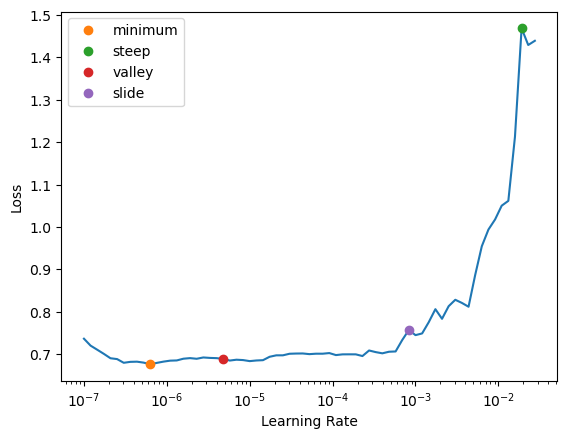

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.658903,0.520388,0.870000,00:22
1,0.207299,0.136384,0.940000,00:23
2,0.122805,0.158376,0.955000,00:22


In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.12280543148517609
valid_loss 0.15837587416172028
accuracy 0.9549999833106995


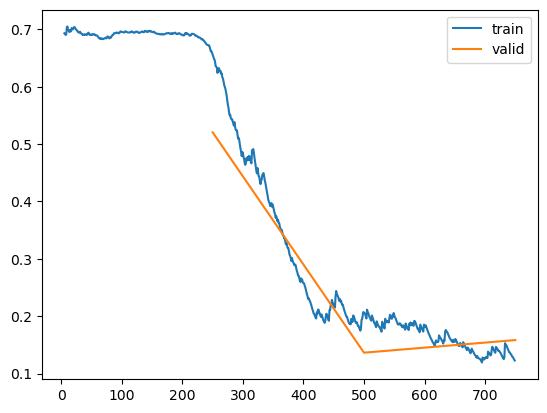

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.show_results(learner=learn, max_n=2, trunc_at=500)

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.export("../models/test_topic_segmentation.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

#### Multilabel

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_new_hf_objects(civil_labels)

=== config ===
# of labels:	7

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `Datasets`

We'll use the Hugging Face `Dataset` objects created in *Setup*, but these could just as well be instances of `torch.utils.data.Dataset`

In [ ]:
print("Train|Validation examples: ", len(civil_train_ds), len(civil_valid_ds))

print(civil_train_ds[:2])
print("")
print(civil_train_ds["text"][:2])

Train|Validation examples:  1000 200
{'text': ['That was a GREAT JOB!!\n\nAnd, alot of work too.  The guy doing the rowing sure got his workout for the day.\n\nI would agree with the comments here that it would be a hunter first and foremost that would take so much trouble and care for a rescue such as this.\n\nI had to chuckle after they turned the moose loose the first time the guy (ranger?) says "Can we get back up on him?"  If I\'m the guy rowing I would have said; "What do you mean WE?  Got a mouse in your pocket?".', "I submit that we don't know what those marches might have impacted, behind closed Washington doors, or what they might have inspired in others, or what might be different if those marches had never happened."], 'toxicity': [0, 0], 'severe_toxicity': [0, 0], 'obscene': [0, 0], 'threat': [0, 0], 'insult': [0, 0], 'identity_attack': [0, 0], 'sexual_explicit': [0, 0], 'is_valid': [False, False]}

['That was a GREAT JOB!!\n\nAnd, alot of work too.  The guy doing the rowi

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    updated_example = dict(hf_tokenizer(example["text"], truncation=True))
    labels = torch.stack([tensor(example[lbl]) for lbl in civil_labels], dim=-1)
    updated_example["label"] = labels

    return updated_example


proc_civil_train_ds = civil_train_ds.map(tokenize_func, batched=True)
# proc_civil_train_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

proc_civil_valid_ds = civil_valid_ds.map(tokenize_func, batched=True, batch_size=4)
# proc_civil_valid_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

print(proc_civil_train_ds)
print(proc_civil_valid_ds)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit', 'is_valid', 'input_ids', 'token_type_ids', 'attention_mask', 'label'],
    num_rows: 1000
})
Dataset({
    features: ['text', 'toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit', 'is_valid', 'input_ids', 'token_type_ids', 'attention_mask', 'label'],
    num_rows: 200
})


##### Step 3: `DataLoaders`

In [ ]:
# build your fastai `DataLoaders` from Pytorch `DataLoader` objects
batch_size = 4
data_collator = TextCollatorWithPadding(hf_tokenizer)
train_dl = torch.utils.data.DataLoader(proc_civil_train_ds, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
valid_dl = torch.utils.data.DataLoader(proc_civil_valid_ds, batch_size=batch_size * 2, shuffle=False, collate_fn=data_collator)

dls = DataLoaders(train_dl, valid_dl)

In [ ]:
print(len(train_dl), len(valid_dl))

b = next(iter(train_dl))
print(len(b))
print("")
print(hf_tokenizer.decode(b[0]["input_ids"][0][:200]))
print("")
print(b[1])

# b

250 25
2

[CLS] I hope they lower rates so I can continue to finance a life I can't afford[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]

tensor([[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]])


In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'show_batch'
# dls.show_batch(dataloaders=dls, max_n=2, trunc_at=800)

##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=BCEWithLogitsLossFlat(),
    metrics=[partial(accuracy_multi, thresh=0.2)],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.loss_func.thresh = 0.15
learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'show_batch'
# learn.dls.valid.show_batch()

In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'one_batch'
# learn.summary()

##### Step 5: Train

SuggestedLRs(minimum=0.0005248074419796466, steep=0.0691830962896347, valley=6.30957365501672e-05, slide=0.0006918309954926372)

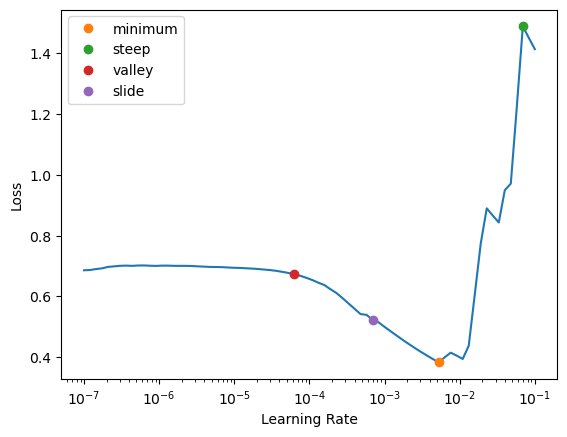

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.131407,0.080277,0.982857,00:15
1,0.072620,0.076287,0.982857,00:15
2,0.066927,0.075918,0.982857,00:14


In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.06692707538604736
valid_loss 0.0759178027510643
accuracy_multi 0.9828571081161499


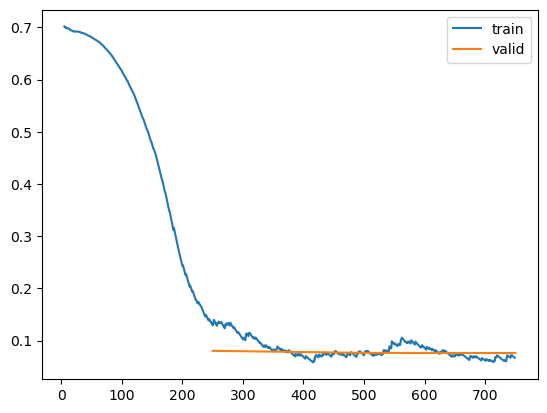

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.show_results(learner=learn, max_n=2, trunc_at=500)

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.export("../models/test_topic_segmentation.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

## Low-Level API: Data

This section demonstrates how you can migrate from using PyTorch/Hugging Face to fast.ai `Datasets` and `DataLoaders` to recapture much of the fast.ai specific features unavailable when using basic PyTorch.

### `TextInput` -

In [ ]:
# |export
class TextInput(TensorBase):
    """The base represenation of your inputs; used by the various fastai `show` methods"""

    pass

A `TextInput` object is returned from the decodes method of `BatchDecodeTransform` as a means to customize `@typedispatch`ed functions like `DataLoaders.show_batch` and `Learner.show_results`. The value will the your "input_ids".

### `BatchDecodeTransform` -

In [ ]:
# |export
class BatchDecodeTransform(Transform):
    """A class used to cast your inputs as `input_return_type` for fastai `show` methods"""

    def __init__(
        self,
        # A Hugging Face tokenizer (not required if passing in an instance of `BatchTokenizeTransform` to `before_batch_tfm`)
        hf_tokenizer: PreTrainedTokenizerBase,
        # The abbreviation/name of your Hugging Face transformer architecture (not required if passing in an instance of `BatchTokenizeTransform` to `before_batch_tfm`)
        hf_arch: str = None,
        # A Hugging Face configuration object (not required if passing in an instance of `BatchTokenizeTransform` to `before_batch_tfm`)
        hf_config: PretrainedConfig = None,
        # A Hugging Face model (not required if passing in an instance of `BatchTokenizeTransform` to `before_batch_tfm`)
        hf_model: PreTrainedModel = None,
        # Used by typedispatched show methods
        input_return_type: type = TextInput,
        # Any other keyword arguments
        **kwargs,
    ):
        store_attr()
        self.kwargs = kwargs

    def decodes(self, items: dict):
        """Returns the proper object and data for show related fastai methods"""
        return self.input_return_type(items["input_ids"])

        # inps = self.input_return_type(items[0]["input_ids"])
        # # inps = self.input_return_type(items[0][0])
        # if len(items) > 1:
        #     return inps, *items[1:]
        # else:
        #     labels = items[0].get("labels", [None] * items[0]["input_ids"])
        #     return inps, labels

As of fastai 2.1.5, before batch transforms no longer have a `decodes` method ... and so, I've introduced a standard batch transform here, `BatchDecodeTransform`, (one that occurs "after" the batch has been created) that will do the decoding for us.

### Utility classes and methods 

These methods are use internally for getting blurr transforms associated to your `DataLoaders`

In [ ]:
# |export
def get_blurr_tfm(
    # A list of transforms (e.g., dls.after_batch, dls.before_batch, etc...)
    tfms_list: Pipeline,
    # The transform to find
    tfm_class: Transform = BatchDecodeTransform,
):
    """
    Given a fastai DataLoaders batch transforms, this method can be used to get at a transform
    instance used in your Blurr DataBlock
    """
    return next(filter(lambda el: issubclass(type(el), tfm_class), tfms_list), None)

In [ ]:
nbdev.show_doc(get_blurr_tfm, title_level=3)

---

[source](https://github.com/ohmeow/blurr/blob/dev-3.0.0 #master/blurr/text/core.py#L272){target="_blank" style="float:right; font-size:smaller"}

### get_blurr_tfm

>      get_blurr_tfm (tfms_list:fastcore.transform.Pipeline,
>                     tfm_class:fastcore.transform.Transform=<class
>                     '__main__.BatchDecodeTransform'>)

Given a fastai DataLoaders batch transforms, this method can be used to get at a transform
instance used in your Blurr DataBlock

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| tfms_list | Pipeline |  | A list of transforms (e.g., dls.after_batch, dls.before_batch, etc...) |
| tfm_class | Transform | BatchDecodeTransform | The transform to find |

In [ ]:
# |export
def first_blurr_tfm(
    # Your fast.ai `DataLoaders
    dls: DataLoaders,
    # The Blurr transforms to look for in order
    tfms: list[Transform] = [BatchDecodeTransform],
):
    """
    This convenience method will find the first Blurr transform required for methods such as
    `show_batch` and `show_results`. The returned transform should have everything you need to properly
    decode and 'show' your Hugging Face inputs/targets
    """
    for tfm in tfms:
        found_tfm = get_blurr_tfm(dls.before_batch, tfm_class=tfm)
        if found_tfm:
            return found_tfm

        found_tfm = get_blurr_tfm(dls.after_batch, tfm_class=tfm)
        if found_tfm:
            return found_tfm

In [ ]:
nbdev.show_doc(first_blurr_tfm, title_level=3)

---

[source](https://github.com/ohmeow/blurr/blob/dev-3.0.0 #master/blurr/text/core.py#L285){target="_blank" style="float:right; font-size:smaller"}

### first_blurr_tfm

>      first_blurr_tfm (dls:fastai.data.core.DataLoaders,
>                       tfms:list[fastcore.transform.Transform]=[<class
>                       '__main__.BatchDecodeTransform'>])

This convenience method will find the first Blurr transform required for methods such as
`show_batch` and `show_results`. The returned transform should have everything you need to properly
decode and 'show' your Hugging Face inputs/targets

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| dls | DataLoaders |  | Your fast.ai `DataLoaders |
| tfms | list[Transform] | [<class '__main__.BatchDecodeTransform'>] | The Blurr transforms to look for in order |

### `show_batch` -

In [ ]:
# |export
@typedispatch
def show_batch(
    # This typedispatched `show_batch` will be called for `TextInput` typed inputs
    x: TextInput,
    # Your targets
    y,
    # Your raw inputs/targets
    samples,
    # Your `DataLoaders`. This is required so as to get at the Hugging Face objects for
    # decoding them into something understandable
    dataloaders,
    # Your `show_batch` context
    ctxs=None,
    # The maximum number of items to show
    max_n=6,
    # Any truncation your want applied to your decoded inputs
    trunc_at=None,
    # Any other keyword arguments you want applied to `show_batch`
    **kwargs,
):
    # grab our tokenizer
    tfm = first_blurr_tfm(dataloaders)
    hf_tokenizer = tfm.hf_tokenizer

    # if we've included our labels list, we'll use it to look up the value of our target(s)
    trg_labels = tfm.kwargs["labels"] if ("labels" in tfm.kwargs) else None

    res = L()
    n_inp = dataloaders.n_inp

    n_samples = min(max_n, dataloaders.bs)
    for idx in range(n_samples):
        input_ids = x[idx]
        label = y[idx] if y is not None else None
        sample = samples[idx] if samples is not None else None

        rets = [hf_tokenizer.decode(input_ids, skip_special_tokens=True)[:trunc_at]]
        for item in sample[n_inp:]:
            if not torch.is_tensor(item):
                trg = trg_labels[int(item)] if trg_labels else item
            elif is_listy(item.tolist()):
                trg = [trg_labels[idx] for idx, val in enumerate(label.numpy().tolist()) if (val == 1)] if (trg_labels) else label.numpy()
            else:
                trg = trg_labels[label.item()] if (trg_labels) else label.item()

            rets.append(trg)
        res.append(tuplify(rets))

    cols = ["text"] + ["target" if (i == 0) else f"target_{i}" for i in range(len(res[0]) - n_inp)]
    display_df(pd.DataFrame(res, columns=cols)[:max_n])
    return ctxs

### `TextDataLoader` -

In [ ]:
# |export
@delegates()
class TextDataLoader(TfmdDL):
    """
    A transformed `DataLoader` that works with Blurr.
    From the fastai docs: A `TfmDL` is described as "a DataLoader that creates Pipeline from a list of Transforms
    for the callbacks `after_item`, `before_batch` and `after_batch`. As a result, it can decode or show a processed batch.
    """

    def __init__(
        self,
        # A standard PyTorch Dataset
        dataset: torch.utils.data.dataset.Dataset | Datasets,
        # A Hugging Face tokenizer (not required if passing in an instance of `BatchTokenizeTransform` to `before_batch_tfm`)
        hf_tokenizer: PreTrainedTokenizerBase,
        # The abbreviation/name of your Hugging Face transformer architecture (not required if passing in an \
        # instance of `BatchTokenizeTransform` to `before_batch_tfm`)
        hf_arch: str = None,
        # A Hugging Face configuration object (not required if passing in an  \
        # instance of `BatchTokenizeTransform` to `before_batch_tfm`)
        hf_config: PretrainedConfig = None,
        # A Hugging Face model (not required if passing in an instance of `BatchTokenizeTransform` to `before_batch_tfm`)
        hf_model: PreTrainedModel = None,
        # An instance of `TextCollatorWithPadding` or equivalent (defaults to `BlurrBatchCreator`)
        text_collator: TextCollatorWithPadding = None,
        # The batch_tfm used to decode Blurr batches (defaults to `BatchDecodeTransform`)
        batch_decode_tfm: BatchDecodeTransform = None,
        # Used by typedispatched show methods
        input_return_type: type = TextInput,
        # Keyword arguments to be applied to your `batch_decode_tfm`
        batch_decode_kwargs: dict = {},
        # Keyword arguments to be applied to `BlurrDataLoader`
        **kwargs,
    ):
        # define what happens when a batch is created (e.g., this is where collation happens)
        if "create_batch" in kwargs:
            kwargs.pop("create_batch")
        if not text_collator:
            text_collator = TextCollatorWithPadding(hf_tokenizer, hf_arch, hf_config, hf_model)

        # define the transform applied after the batch is created (used of show methods)
        if "after_batch" in kwargs:
            kwargs.pop("after_batch")
        if not batch_decode_tfm:
            batch_decode_tfm = BatchDecodeTransform(
                hf_tokenizer,
                hf_arch,
                hf_config,
                hf_model,
                input_return_type,
                **batch_decode_kwargs.copy(),
            )

        super().__init__(
            dataset=dataset,
            create_batch=text_collator,
            after_batch=batch_decode_tfm,
            **kwargs,
        )
        store_attr()

    def new(
        self,
        # A standard PyTorch and fastai dataset
        dataset: Union[torch.utils.data.dataset.Dataset, Datasets] = None,
        # The class you want to create an instance of (will be "self" if None)
        cls: type = None,
        #  Any additional keyword arguments you want to pass to the __init__ method of `cls`
        **kwargs,
    ):
        """
        We have to override the new method in order to add back the Hugging Face objects in this factory
        method (called for example in places like `show_results`). With the exception of the additions to the kwargs
        dictionary, the code below is pulled from the `DataLoaders.new` method as is.
        """
        # we need to add these arguments back in (these, after_batch, and create_batch will go in as kwargs)
        kwargs["hf_arch"] = self.hf_arch
        kwargs["hf_config"] = self.hf_config
        kwargs["hf_tokenizer"] = self.hf_tokenizer
        kwargs["hf_model"] = self.hf_model

        kwargs["text_collator"] = self.text_collator
        kwargs["batch_decode_tfm"] = self.batch_decode_tfm
        kwargs["batch_decode_kwargs"] = self.batch_decode_kwargs

        return super().new(dataset, cls, **kwargs)

### `sorted_dl_func` -

In [ ]:
# |export
def sorted_dl_func(
    example,
    # A Hugging Face tokenizer
    hf_tokenizer: PreTrainedTokenizerBase,
    # The `is_split_into_words` argument applied to your `hf_tokenizer` during tokenization. \
    # Set this to 'True' if your inputs are pre-tokenized (not numericalized)
    is_split_into_words: bool = False,
    # Any other keyword arguments you want to include during tokenization
    tok_kwargs: dict = {},
):
    """This method is used by the `SortedDL` to ensure your dataset is sorted *after* tokenization"""
    txt = None
    if isinstance(example[0], dict):
        if "input_ids" in example[0]:
            # if inputs are pretokenized
            return len(example[0]["input_ids"])
        else:
            txt = example[0]["text"]
    else:
        txt = example[0]

    return len(txt) if is_split_into_words else len(hf_tokenizer.tokenize(txt, **tok_kwargs))

In [ ]:
nbdev.show_doc(sorted_dl_func, title_level=3)

---

[source](https://github.com/ohmeow/blurr/blob/dev-3.0.0 #master/blurr/text/core.py#L446){target="_blank" style="float:right; font-size:smaller"}

### sorted_dl_func

>      sorted_dl_func (example, hf_tokenizer:transformers.tokenization_utils_bas
>                      e.PreTrainedTokenizerBase,
>                      is_split_into_words:bool=False, tok_kwargs:dict={})

This method is used by the `SortedDL` to ensure your dataset is sorted *after* tokenization

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| example |  |  |  |
| hf_tokenizer | PreTrainedTokenizerBase |  | A Hugging Face tokenizer |
| is_split_into_words | bool | False | The `is_split_into_words` argument applied to your `hf_tokenizer` during tokenization. \<br>Set this to 'True' if your inputs are pre-tokenized (not numericalized) |
| tok_kwargs | dict | {} | Any other keyword arguments you want to include during tokenization |

## Low-Level API: Training

In this section, we include a custom `show_results()` method that will work with fast.ai's low-level and mid-level (think `DataBlock`) APIs.

### `show_results` -

In [ ]:
# |export
@typedispatch
def show_results(
    # This typedispatched `show_results` will be called for `TextInput` typed inputs
    x: TextInput,
    # Your targets
    y,
    # Your raw inputs/targets
    samples,
    # The model's predictions
    outs,
    # Your `Learner`. This is required so as to get at the Hugging Face objects for decoding them into
    # something understandable
    learner,
    # Your `show_results` context
    ctxs=None,
    # The maximum number of items to show
    max_n=6,
    # Any truncation your want applied to your decoded inputs
    trunc_at=None,
    # Any other keyword arguments you want applied to `show_results`
    **kwargs,
):
    # grab our tokenizer
    tfm = first_blurr_tfm(learner.dls)
    hf_tokenizer = tfm.hf_tokenizer

    # if we've included our labels list, we'll use it to look up the value of our target(s)
    trg_labels = tfm.kwargs["labels"] if ("labels" in tfm.kwargs) else None

    res = L()
    n_inp = learner.dls.n_inp

    n_samples = min(max_n, learner.dls.bs)
    for idx in range(n_samples):
        input_ids = x[idx]
        label = y[idx] if y is not None else None
        pred = outs[idx]
        sample = samples[idx] if samples is not None else None
        # add in the input text
        rets = [hf_tokenizer.decode(input_ids, skip_special_tokens=True)[:trunc_at]]
        # add in the targets
        for item in sample[n_inp:]:
            if not torch.is_tensor(item):
                trg = trg_labels[int(item)] if trg_labels else item
            elif is_listy(item.tolist()):
                trg = [trg_labels[idx] for idx, val in enumerate(label.numpy().tolist()) if (val == 1)] if (trg_labels) else label.numpy()
            else:
                trg = trg_labels[label.item()] if (trg_labels) else label.item()

            rets.append(trg)
        # add in the predictions
        for item in pred:
            if not torch.is_tensor(item):
                p = trg_labels[int(item)] if trg_labels else item
            elif is_listy(item.tolist()):
                p = [trg_labels[idx] for idx, val in enumerate(label.numpy().tolist()) if (val == 1)] if (trg_labels) else label.numpy()
            else:
                p = trg_labels[label.item()] if (trg_labels) else label.item()

            rets.append(p)

        res.append(tuplify(rets))

    cols = ["text"] + ["target" if (i == 0) else f"target_{i}" for i in range(len(res[0]) - n_inp * 2)]
    cols += ["prediction" if (i == 0) else f"prediction_{i}" for i in range(len(res[0]) - n_inp * 2)]
    display_df(pd.DataFrame(res, columns=cols)[:max_n])
    return ctxs

## Low-Level API: Examples

### Using fast.ai `Datasets` and `DataLoaders`

#### Multiclass

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_new_hf_objects(labels)

=== config ===
# of labels:	2

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `Datasets`

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    return hf_tokenizer(example["text"], truncation=True)


proc_imdb_ds = imdb_ds.map(tokenize_func, batched=True)
proc_imdb_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

# turn Arrow into DataFrame (`ColSplitter` only works with `DataFrame`s)
train_df = pd.DataFrame(proc_imdb_ds)
train_df.head()

# define dataset splitter
splitter = ColSplitter("is_valid")
splits = splitter(imdb_df)


# define how we want to build our inputs and targets
def _build_inputs(example):
    return {fwd_arg_name: example[fwd_arg_name] for fwd_arg_name in hf_tokenizer.model_input_names if fwd_arg_name in list(example.keys())}


def _build_targets(example):
    return example["label"]


# create our fastai `Datasets` object
dsets = Datasets(items=train_df, splits=splits, tfms=[[_build_inputs], _build_targets], n_inp=1)

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

In [ ]:
print("Items in train|validation datasets: ", len(dsets.train), len(dsets.valid))

example = dsets.valid[0]
# example

print(f"Items in each example: {len(example)}")
print(f"Example inputs: {list(example[0].keys())}")
print(f"Example target(s): {example[1]}")

Items in train|validation datasets:  1000 200
Items in each example: 2
Example inputs: ['input_ids', 'token_type_ids', 'attention_mask']
Example target(s): 0


##### Step 3: `DataLoaders`

In [ ]:
data_collator = TextCollatorWithPadding(hf_tokenizer)
sort_func = partial(sorted_dl_func, hf_tokenizer=hf_tokenizer)

dls = dsets.dataloaders(
    batch_size=4,
    create_batch=data_collator,
    dl_type=partial(SortedDL, sort_func=sort_func),
)

In [ ]:
print(len(dls.train), len(dls.valid))

b = dls.valid.one_batch()
print(len(b))
print("")
print(hf_tokenizer.decode(b[0]["input_ids"][0][:200]))
print("")
print(b[1])

250 50
2

[CLS] I must have been in a good mood to give this shameful, predictable, embarrassing movie even a 3. What's wrong with it? Let's start with the gratuitous sex although I admit the rotational style of bonking was something I had not seen (nor experienced) before. And I guess they also saved a few bucks by showing the same sex scene three times. Then there are the inconsistencies. The "Oakville Tribune" seems to be in a green part of whatever town it was supposed to be. (Hamilton Ontario???) Yet in the scenes on the roof, it appears to be in an industrial area with a steel mill belching smoke and flames. Also, the inside of the building --- the newsroom --- the stairways --- seem much bigger than the outside. SPOILERS HERE Then, when our intrepid reporter finally gets fired, she comes back to the building several times, once after hours. Hardly likely. The ending is also pitifully predictable

tensor([0, 1, 0, 1], device='cuda:0')


In [ ]:
# NOPE: Won't work with fastai Datasets/DataLoaders without transforms
# RecursionError: maximum recursion depth exceeded while calling a Python object
# dls.show_batch(dataloaders=dls, max_n=2, trunc_at=800)

##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# NOPE: Won't work with fastai Datasets/DataLoaders without transforms
# RecursionError: maximum recursion depth exceeded while calling a Python object
# learn.dls.valid.show_batch()

In [ ]:
# YES: Since we're using fastai `DataLoaders`, we get `one_batch()` back
learn.summary()

BaseModelWrapper (Input shape: 4 x 1520)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 1520 x 768      
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 1520 x 3072     
Linear                        

##### Step 5: Train

SuggestedLRs(minimum=0.00010000000474974513, steep=0.0008317637839354575, valley=0.0003311311302240938, slide=0.0002754228771664202)

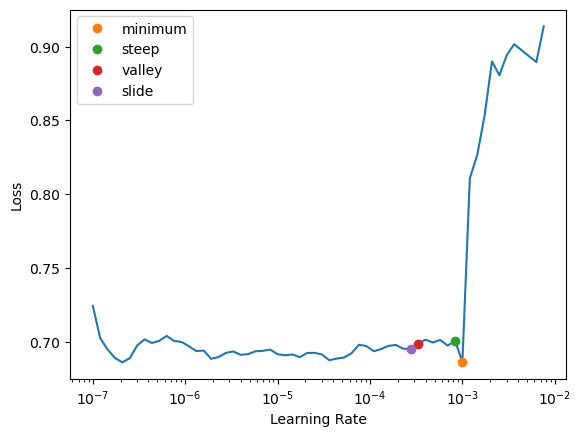

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.683307,0.641457,0.725000,00:19
1,0.239924,0.164144,0.940000,00:20
2,0.151697,0.161079,0.950000,00:20


In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.15169674158096313
valid_loss 0.1610793173313141
accuracy 0.949999988079071


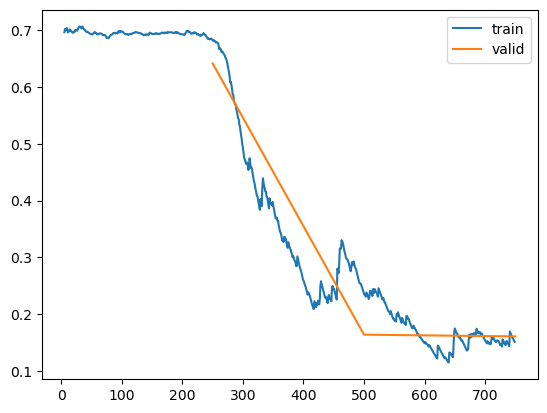

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# NOPE: Won't work with fastai Datasets/DataLoaders without transforms
# RecursionError: maximum recursion depth exceeded in __instancecheck__
# learn.show_results(learner=learn, max_n=2, trunc_at=500)

In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`
# AttributeError: 'DataLoader' object has no attribute 'new'
learn.export("../models/test_text_core_low_level.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

#### Multilabel

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_new_hf_objects(civil_labels)

=== config ===
# of labels:	7

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `Datasets`

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    updated_example = dict(hf_tokenizer(example["text"], truncation=True))
    labels = torch.stack([tensor(example[lbl]) for lbl in civil_labels], dim=-1)
    updated_example["label"] = labels

    return updated_example


proc_civil_ds = civil_ds.map(tokenize_func, batched=True)
proc_civil_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

# turn Arrow into DataFrame (`ColSplitter` only works with `DataFrame`s)
train_df = pd.DataFrame(proc_civil_ds)
train_df.head()

# define dataset splitter
splitter = ColSplitter("is_valid")
splits = splitter(civil_df)


# define how we want to build our inputs and targets
def _build_inputs(example):
    return {fwd_arg_name: example[fwd_arg_name] for fwd_arg_name in hf_tokenizer.model_input_names if fwd_arg_name in list(example.keys())}


def _build_targets(example):
    return example["label"]


# create our fastai `Datasets` object
dsets = Datasets(items=train_df, splits=splits, tfms=[[_build_inputs], _build_targets], n_inp=1)

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

In [ ]:
print("Items in train|validation datasets: ", len(dsets.train), len(dsets.valid))

example = dsets.valid[0]
# example

print(f"Items in each example: {len(example)}")
print(f"Example inputs: {list(example[0].keys())}")
print(f"Example target(s): {example[1]}")

Items in train|validation datasets:  1000 200
Items in each example: 2
Example inputs: ['input_ids', 'token_type_ids', 'attention_mask']
Example target(s): tensor([0, 0, 0, 0, 0, 0, 0])


##### Step 3: `DataLoaders`

In [ ]:
data_collator = TextCollatorWithPadding(hf_tokenizer)
sort_func = partial(sorted_dl_func, hf_tokenizer=hf_tokenizer)
dls = dsets.dataloaders(
    batch_size=4,
    create_batch=data_collator,
    dl_type=partial(SortedDL, sort_func=sort_func),
)

In [ ]:
print(len(dls.train), len(dls.valid))

b = dls.valid.one_batch()
print(len(b))
print("")
print(hf_tokenizer.decode(b[0]["input_ids"][0][:200]))
print("")
print(b[1])

250 50
2

[CLS] Good job reporting this 13 hours later. At leat there's other news sources.[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]

tensor([[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]], device='cuda:0')


In [ ]:
# NOPE: Won't work with fastai Datasets/DataLoaders without transforms
# RecursionError: maximum recursion depth exceeded while calling a Python object
# dls.show_batch(dataloaders=dls, max_n=2, trunc_at=800)

##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=BCEWithLogitsLossFlat(),
    metrics=[partial(accuracy_multi, thresh=0.2)],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.loss_func.thresh = 0.15
learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# NOPE: Won't work with fastai Datasets/DataLoaders without transforms
# RecursionError: maximum recursion depth exceeded while calling a Python object
# learn.dls.valid.show_batch()

In [ ]:
# YES: Since we're using fastai `DataLoaders`, we get `one_batch()` back
learn.summary()

BaseModelWrapper (Input shape: 4 x 261)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 261 x 768       
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 261 x 3072      
Linear                         

##### Step 5: Train

SuggestedLRs(minimum=0.00043651582673192023, steep=0.04786301031708717, valley=0.00010964782268274575, slide=0.0010000000474974513)

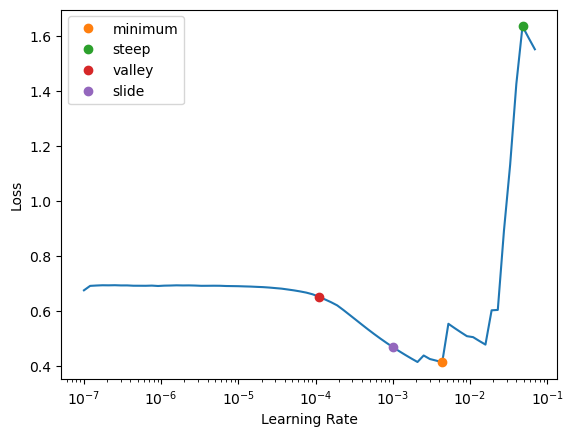

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.163759,0.076675,0.982857,00:18
1,0.069312,0.076567,0.982857,00:17
2,0.057330,0.074451,0.982857,00:18


In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.05732974037528038
valid_loss 0.07445084303617477
accuracy_multi 0.9828572273254395


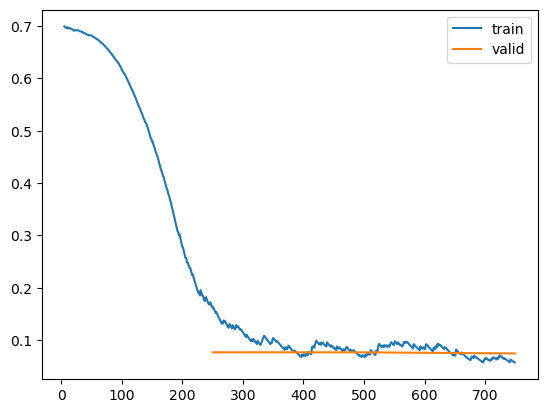

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# NOPE: Won't work with fastai Datasets/DataLoaders without transforms
# RecursionError: maximum recursion depth exceeded in __instancecheck__
# learn.show_results(learner=learn, max_n=2, trunc_at=500)

In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`
# AttributeError: 'DataLoader' object has no attribute 'new'
learn.export("../models/test_text_core_low_level_multilabel.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

### Using `BatchDecodeTransform` and `TextDataLoader`

#### Multiclass

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_new_hf_objects(labels)

=== config ===
# of labels:	2

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `Dataset`s

We'll use the Hugging Face `Dataset` objects created in *Setup*, but these could just as well be instances of `torch.utils.data.Dataset`

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    return hf_tokenizer(example["text"], truncation=True)


proc_imdb_ds = imdb_ds.map(tokenize_func, batched=True)
# proc_imdb_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])


# define dataset splitter
def _split_func(example):
    return example["is_valid"] == True


splitter = FuncSplitter(_split_func)
splits = splitter(proc_imdb_ds)


# define how we want to build our inputs and targets
def _build_inputs(example):
    return {fwd_arg_name: example[fwd_arg_name] for fwd_arg_name in hf_tokenizer.model_input_names if fwd_arg_name in list(example.keys())}


def _build_targets(example):
    return example["label"]


# create our fastai `Datasets` object
dsets = Datasets(items=proc_imdb_ds, splits=splits, tfms=[[_build_inputs], _build_targets], n_inp=1)

Loading cached processed dataset at /home/wgilliam/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-c40b9a731424a4a7.arrow


##### Step 3: `DataLoaders`

In [ ]:
label_names = train_ds.features["label"].names
label_names

['neg', 'pos']

In [ ]:
batch_size = 4

trn_dl = TextDataLoader(
    dsets.train,
    hf_tokenizer,
    batch_decode_kwargs={"labels": label_names},
    shuffle=True,
    batch_size=batch_size,
)

val_dl = TextDataLoader(
    dsets.valid,
    hf_tokenizer,
    batch_decode_kwargs={"labels": label_names},
    batch_size=batch_size * 2,
)

dls = DataLoaders(trn_dl, val_dl)

In [ ]:
print(len(dls.train), len(dls.valid))

b = dls.valid.one_batch()
print(len(b))
print("")
print(hf_tokenizer.decode(b[0]["input_ids"][0][:200]))
print("")
print(b[1])

250 25
2

[CLS] I must have been in a good mood to give this shameful, predictable, embarrassing movie even a 3. What's wrong with it? Let's start with the gratuitous sex although I admit the rotational style of bonking was something I had not seen (nor experienced) before. And I guess they also saved a few bucks by showing the same sex scene three times. Then there are the inconsistencies. The "Oakville Tribune" seems to be in a green part of whatever town it was supposed to be. (Hamilton Ontario???) Yet in the scenes on the roof, it appears to be in an industrial area with a steel mill belching smoke and flames. Also, the inside of the building --- the newsroom --- the stairways --- seem much bigger than the outside. SPOILERS HERE Then, when our intrepid reporter finally gets fired, she comes back to the building several times, once after hours. Hardly likely. The ending is also pitifully predictable

tensor([0, 1, 0, 1, 0, 1, 1, 0])


In [ ]:
# YES: Since we're using fastai `TfmDL` and including a transform that knows how to show our inputs,
# we get `show_results()` back
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=800)

,text,target
0,"Very funny, well-crafted, well-acted, meticulous attention to detail. A real window into a specific time and place in history. Could almost believe this was a true story in a parallel universe. Interesting how Passport to Pimlico anticipates the Berlin airlift. A definite 10.",pos
1,"Good: Engaging cinematic firefights, great presentation, vehicles are actually fun to drive, fairly appealing multiplayer, faithful to the movie, and the list goes on.<br /><br />Bad: Main missions are a bit short.<br /><br />This game defines what a ""good"" third person shooter(not necessarily a spy-game) is. Great firefights carry on the story and make you want to complete EVERY single mission through, and unlock all the genuine bonuses the game has to offer. The hype this game had, was lived up to, and I personally think you should buy it, and hook up with a couple of friends and play this one. Loads of fun. <br /><br />The sound in this game, is a rip-roaring achievement from a few previous bond games, and firing a weapon, really feels like you're firing a weapon. It ties in with the as",pos


##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# YES: Since we're using fastai `TfmDL` and including a transform that knows how to show our inputs,
# we get `show_batch()` back
learn.dls.valid.show_batch(dataloaders=learn.dls, max_n=2, trunc_at=250)

,text,target
0,"I must have been in a good mood to give this shameful, predictable, embarrassing movie even a 3. What's wrong with it? Let's start with the gratuitous sex although I admit the rotational style of bonking was something I had not seen (nor experienced)",neg
1,It's amazing what you can do with little money. DEAD SILENT being a low budget movie delivers its promises. <br /><br />Too bad we don't see Rob Lowe more often on the silver screen. Lowe is at its best in this riveting thriller. No wonder he went fr,pos


In [ ]:
# YES: Will work now that we're using fastai `TfmDL`s` and transforms
learn.summary()

BaseModelWrapper (Input shape: 4 x 312)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 312 x 768       
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 312 x 3072      
Linear                         

##### Step 5: Train

SuggestedLRs(minimum=6.309573450380412e-08, steep=0.001737800776027143, valley=0.0010000000474974513, slide=0.0005754399462603033)

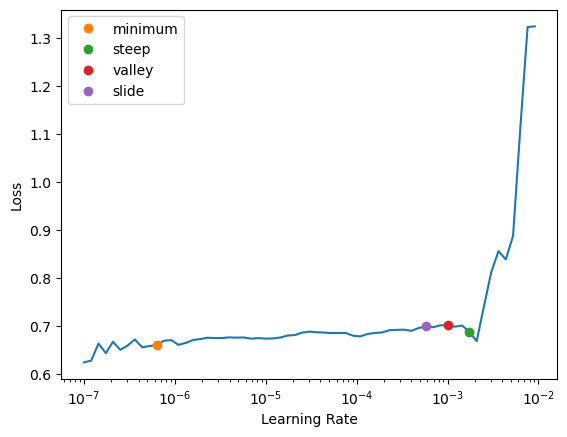

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.547859,0.614689,0.805000,00:25
1,0.240205,0.181035,0.940000,00:25
2,0.140356,0.153366,0.945000,00:26


In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.14035610854625702
valid_loss 0.15336614847183228
accuracy 0.9449999928474426


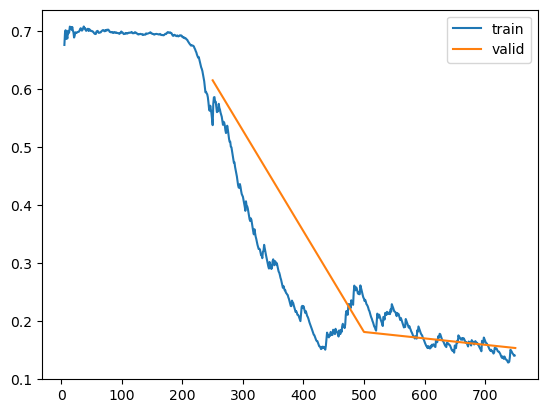

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# YES: Since we're using fastai `TfmDL` and including a transform that knows how to show our inputs,
# we get `show_results()` back
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,text,target,prediction
0,"This film just doesn't work. No two ways about it. I saw it for the first time back in '98 when it was released and I didn't like it. I just bought it on sale a couple of days ago, 'cause I thought ""whatta hell, I'll give it a try"". I don't regret for the money I put out for Hamilton, but the fact remained the same.. this movie is pointless, dull and uninteresting.<br /><br />Stormare is usually a delight, but that's when he's making films in the US. Back home he doesn't do the trick. Sure the m",neg,neg
1,"This movie doesn't even deserve a 1/10 This movie was a scam.<br /><br />I swear that at least 30 minutes of the film were DELIBERETLY copied from Carnosaur 1, 2, & 3.The whole movie ""Raptor"" was based of the movie and that was really a pathetic attempt to be a ""Thriller, Action Packed, Dinosaur"" copy. I loved that movie series and seeing it be put on a movie that cant even afford or willing COPY it without doing there own models is what America is coming to.I recommend you see the Carnosaur mov",neg,neg


In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`, and transforms
learn.export("../models/test_text_core_low_level.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

#### Multilabel

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_new_hf_objects(civil_labels)

=== config ===
# of labels:	7

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `Dataset`s

We'll use the Hugging Face `Dataset` objects created in *Setup*, but these could just as well be instances of `torch.utils.data.Dataset`

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    updated_example = dict(hf_tokenizer(example["text"], truncation=True))
    labels = torch.stack([tensor(example[lbl]) for lbl in civil_labels], dim=-1)
    updated_example["label"] = labels

    return updated_example


proc_civil_ds = civil_ds.map(tokenize_func, batched=True)
# proc_imdb_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])


# define dataset splitter
def _split_func(example):
    return example["is_valid"] == True


splitter = FuncSplitter(_split_func)
splits = splitter(proc_civil_ds)


# define how we want to build our inputs and targets
def _build_inputs(example):
    return {fwd_arg_name: example[fwd_arg_name] for fwd_arg_name in hf_tokenizer.model_input_names if fwd_arg_name in list(example.keys())}


def _build_targets(example):
    return example["label"]


# create our fastai `Datasets` object
dsets = Datasets(items=proc_civil_ds, splits=splits, tfms=[[_build_inputs], _build_targets], n_inp=1)

Loading cached processed dataset at /home/wgilliam/.cache/huggingface/datasets/civil_comments/default/0.9.0/e7a3aacd2ab7d135fa958e7209d10b1fa03807d44c486e3c34897aa08ea8ffab/cache-9c8ac686fbc765a4.arrow


##### Step 3: `DataLoaders`

In [ ]:
batch_size = 4

trn_dl = TextDataLoader(
    dsets.train,
    hf_tokenizer,
    batch_decode_kwargs={"labels": civil_labels},
    shuffle=True,
    batch_size=batch_size,
)

val_dl = TextDataLoader(
    dsets.valid,
    hf_tokenizer,
    batch_decode_kwargs={"labels": civil_labels},
    batch_size=batch_size * 2,
)

dls = DataLoaders(trn_dl, val_dl)

In [ ]:
print(len(dls.train), len(dls.valid))

b = dls.valid.one_batch()
print(len(b))
print("")
print(hf_tokenizer.decode(b[0]["input_ids"][0][:200]))
print("")
print(b[1])

250 25
2

[CLS] Good job reporting this 13 hours later. At leat there's other news sources.[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]

tensor([[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]])


In [ ]:
# YES: Since we're using fastai `TfmDL` and including a transform that knows how to show our inputs,
# we get `show_batch()` back
dls.show_batch(dataloaders=dls, max_n=8)

,text,target
0,"WW just censored my comments on burny sanders, the fake democrat in this primary. i called him no bad names or used bad language. WW uses censorship to prop up their candidate.",[]
1,Trump is right. They had a surplus of money and we were getting nothing from them. The least they should have been doing is paying us for our help.,[]
2,"Stick to topics you know something about. That doesn't solve the problem. It just puts the congestion on the walk-in trails. I'd much rather shoot game to avoid eating your chemically injected, slaughterhouse cow. But, I suppose your ultimate goal is to eliminate hunting and guns.",[]
3,"No father or mother want to see this happen to a child, and there is a child without a father now. EPD please work hard to find the people responsible. Heart breaking, may God bless the family.",[]


##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=BCEWithLogitsLossFlat(),
    metrics=[partial(accuracy_multi, thresh=0.2)],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.loss_func.thresh = 0.15
learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# YES: Since we're using fastai `TfmDL` and including a transform that knows how to show our inputs,
# we get `show_batch()` back
learn.dls.valid.show_batch(dataloaders=learn.dls, max_n=2, trunc_at=250)

,text,target
0,Good job reporting this 13 hours later. At leat there's other news sources.,[]
1,I wonder if they still think there is no such thing as bad PR,[]


In [ ]:
# YES: Since we're using fastai `DataLoaders`, we get `learn.summary()` back
learn.summary()

BaseModelWrapper (Input shape: 4 x 173)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 173 x 768       
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 173 x 3072      
Linear                         

##### Step 5: Train

SuggestedLRs(minimum=0.0005248074419796466, steep=0.03981071710586548, valley=7.585775892948732e-05, slide=0.0020892962347716093)

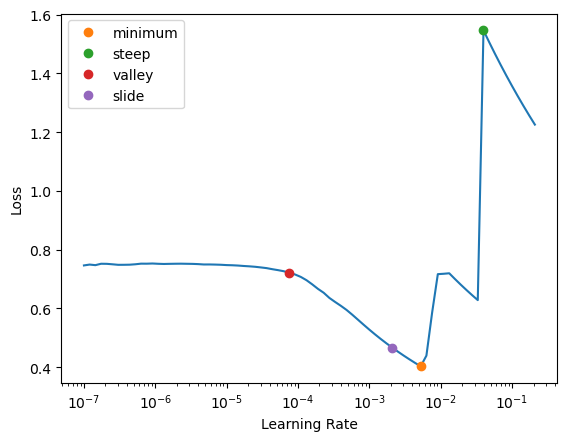

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.168259,0.077203,0.982857,00:17
1,0.073645,0.076845,0.982857,00:16
2,0.074043,0.076767,0.982857,00:17


In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.0740433931350708
valid_loss 0.07676685601472855
accuracy_multi 0.9828571081161499


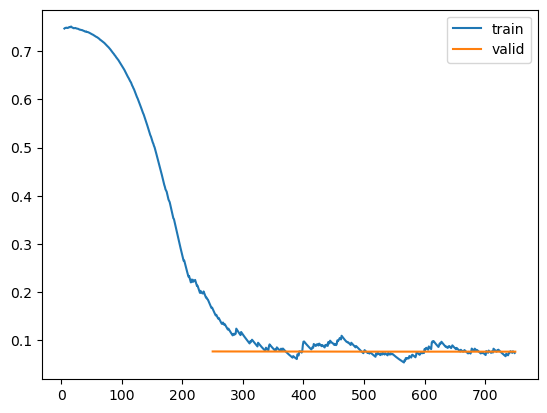

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# YES: Since we're using fastai `TfmDL` and including a transform that knows how to show our inputs,
# we get `show_results()` back
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,text,target,prediction
0,"Thank you for a comment that is positive, helpful and thought provoking.",[],[]
1,"Have y'all forgotten the commands of the bible? The word of God is clear on this, women need to be subservient to men, whom is seen as the head of the family. Seems to me you cannot be a feminist supporter and a christian at the same time, that would be hypocritical.",[],[]


In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`, and transforms
learn.export("../models/test_text_core_low_level_multilabel.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

## Mid-Level API: Data

BLURR's mid-level API provides a way to build your `DataLoaders` using fast.ai's mid-level `DataBlock` API.  

BLURR supports three ways of doing this in the mid-level API: 

1. Using pre-tokenized data (the traditional approach)

2. batch-time tokenization (the default approach in previous versions of blurr)

2. item-time tokenization (e.g., to apply tokenization on individual items as they are pulled from their respective `Dataset`)

### `BatchTokenizeTransform` -

In [ ]:
# |export
class BatchTokenizeTransform(Transform):
    """
    Handles everything you need to assemble a mini-batch of inputs and targets, as well as
    decode the dictionary produced as a byproduct of the tokenization process in the `encodes` method.
    """

    def __init__(
        self,
        # The abbreviation/name of your Hugging Face transformer architecture (e.b., bert, bart, etc..)
        hf_arch: str,
        # A specific configuration instance you want to use
        hf_config: PretrainedConfig,
        # A Hugging Face tokenizer
        hf_tokenizer: PreTrainedTokenizerBase,
        # A Hugging Face model
        hf_model: PreTrainedModel,
        # To control whether the "labels" are included in your inputs. If they are, the loss will be calculated in \
        # the model's forward function and you can simply use `PreCalculatedLoss` as your `Learner`'s loss function to use it
        include_labels: bool = True,
        # The token ID that should be ignored when calculating the loss
        ignore_token_id: int = CrossEntropyLossFlat().ignore_index,
        # To control the length of the padding/truncation. It can be an integer or None, \
        # in which case it will default to the maximum length the model can accept. \
        # If the model has no specific maximum input length, truncation/padding to max_length is deactivated. \
        # See [Everything you always wanted to know about padding and truncation](https://huggingface.co/transformers/preprocessing.html#everything-you-always-wanted-to-know-about-padding-and-truncation)
        max_length: int = None,
        # To control the `padding` applied to your `hf_tokenizer` during tokenization. \
        # If None, will default to 'False' or 'do_not_pad'. \
        # See [Everything you always wanted to know about padding and truncation](https://huggingface.co/transformers/preprocessing.html#everything-you-always-wanted-to-know-about-padding-and-truncation)
        padding: bool | str = True,
        # To control `truncation` applied to your `hf_tokenizer` during tokenization. \
        # If None, will default to 'False' or 'do_not_truncate'. \
        # See [Everything you always wanted to know about padding and truncation](https://huggingface.co/transformers/preprocessing.html#everything-you-always-wanted-to-know-about-padding-and-truncation)
        truncation: bool | str = True,
        # The `is_split_into_words` argument applied to your `hf_tokenizer` during tokenization. \
        # Set this to 'True' if your inputs are pre-tokenized (not numericalized) \
        is_split_into_words: bool = False,
        # Any other keyword arguments you want included when using your `hf_tokenizer` to tokenize your inputs
        tok_kwargs: dict = {},
        # Keyword arguments to apply to `BatchTokenizeTransform`
        **kwargs,
    ):
        store_attr()
        self.kwargs = kwargs

    def encodes(self, samples, return_batch_encoding=False):
        """
        This method peforms on-the-fly, batch-time tokenization of your data. In other words, your raw inputs
        are tokenized as needed for each mini-batch of data rather than requiring pre-tokenization of your full
        dataset ahead of time.
        """
        samples = L(samples)

        # grab inputs
        is_dict = isinstance(samples[0][0], dict)
        test_inp = samples[0][0]["text"] if is_dict else samples[0][0]

        if is_listy(test_inp) and not self.is_split_into_words:
            if is_dict:
                inps = [(item["text"][0], item["text"][1]) for item in samples.itemgot(0).items]
            else:
                inps = list(zip(samples.itemgot(0, 0), samples.itemgot(0, 1)))
        else:
            inps = [item["text"] for item in samples.itemgot(0).items] if is_dict else samples.itemgot(0).items

        inputs = self.hf_tokenizer(
            inps,
            max_length=self.max_length,
            padding=self.padding,
            truncation=self.truncation,
            is_split_into_words=self.is_split_into_words,
            return_tensors="pt",
            **self.tok_kwargs,
        )

        d_keys = inputs.keys()

        # update the samples with tokenized inputs (e.g. input_ids, attention_mask, etc...), as well as extra information
        # if the inputs is a dictionary.
        # (< 2.0.0): updated_samples = [(*[{k: inputs[k][idx] for k in d_keys}], *sample[1:]) for idx, sample in enumerate(samples)]
        updated_samples = []
        for idx, sample in enumerate(samples):
            inps = {k: inputs[k][idx] for k in d_keys}
            if is_dict:
                inps = {
                    **inps,
                    **{k: v for k, v in sample[0].items() if k not in ["text"]},
                }

            trgs = sample[1:]
            if self.include_labels and len(trgs) > 0:
                inps["labels"] = trgs[0]

            updated_samples.append((*[inps], *trgs))

        if return_batch_encoding:
            return updated_samples, inputs

        return updated_samples

Inspired by this [article](https://docs.fast.ai/tutorial.transformers.html), `BatchTokenizeTransform` inputs can come in as raw **text**, **a list of words** (e.g., tasks like Named Entity Recognition (NER), where you want to predict the label of each token), or as a **dictionary** that includes extra information you want to use during post-processing.

**On-the-fly Batch-Time Tokenization**: 

Part of the inspiration for this derives from the mechanics of Hugging Face tokenizers, in particular it can return a collated mini-batch of data given a list of sequences. As such, the collating required for our inputs can be done during tokenization ***before*** our batch transforms run in a `before_batch_tfms` transform (where we get a list of examples)! This allows users of BLURR to have everything done dynamically at batch-time without prior preprocessing with at least four potential benefits:
1. Less code
2. Faster mini-batch creation
3. Less RAM utilization and time spent tokenizing beforehand (this really helps with very large datasets)
4. Flexibility

### `TextBlock` -

In [ ]:
# |export
class TextBlock(TransformBlock):
    """The core `TransformBlock` to prepare your inputs for training in Blurr with fastai's `DataBlock` API"""

    def __init__(
        self,
        # The abbreviation/name of your Hugging Face transformer architecture (not required if passing in an \
        # instance of `BatchTokenizeTransform` to `before_batch_tfm`)
        hf_arch: str = None,
        # A Hugging Face configuration object (not required if passing in an \
        # instance of `BatchTokenizeTransform` to `before_batch_tfm`)
        hf_config: PretrainedConfig = None,
        # A Hugging Face tokenizer (not required if passing in an \
        # instance of `BatchTokenizeTransform` to `before_batch_tfm`)
        hf_tokenizer: PreTrainedTokenizerBase = None,
        # A Hugging Face model (not required if passing in an \
        # instance of `BatchTokenizeTransform` to `before_batch_tfm`)
        hf_model: PreTrainedModel = None,
        # The "before_batch" transform you want to use if tokenizing your raw data on the fly (optional)
        tokenize_tfm: Transform = None,
        # The batch_tfm you want to decode your inputs into a type that can be used in the fastai show methods, \
        # (defaults to BatchDecodeTransform)
        batch_decode_tfm: BatchDecodeTransform = None,
        # To control whether the "labels" are included in your inputs. If they are, the loss will be calculated in \
        # the model's forward function and you can simply use `PreCalculatedLoss` as your `Learner`'s loss function to use it
        include_labels: bool = True,
        # The `is_split_into_words` argument applied to your `hf_tokenizer` during tokenization. \
        # Set this to `True` if your inputs are pre-tokenized (not numericalized)
        is_split_into_words: bool = False,
        # The return type your decoded inputs should be cast too (used by methods such as `show_batch`)
        input_return_type: type = TextInput,
        # The type of `DataLoader` you want created (defaults to `SortedDL`)
        dl_type: DataLoader = None,
        # Any keyword arguments you want applied to your `batch_decode_tfm` (will be set as a fastai `batch_tfms`)
        batch_decode_kwargs: dict = {},
        # Any keyword arguments you want your Hugging Face tokenizer to use during tokenization
        tok_kwargs: dict = {},
        # Any keyword arguments you want to have applied with generating text
        text_gen_kwargs: dict = {},
        # Any keyword arguments you want applied to `TextBlock`
        **kwargs,
    ):
        if (not all([hf_arch, hf_config, hf_tokenizer, hf_model])) and tokenize_tfm is None:
            raise ValueError("You must supply an hf_arch, hf_config, hf_tokenizer, hf_model -or- a tokenize_tfm")

        # if we are using a transform to tokenize our inputs, grab the HF objects from it
        if tokenize_tfm is not None:
            hf_arch = getattr(tokenize_tfm, "hf_arch", hf_arch)
            hf_config = getattr(tokenize_tfm, "hf_config", hf_config)
            hf_tokenizer = getattr(tokenize_tfm, "hf_tokenizer", hf_tokenizer)
            hf_model = getattr(tokenize_tfm, "hf_model", hf_model)
            is_split_into_words = getattr(tokenize_tfm, "is_split_into_words", is_split_into_words)
            include_labels = getattr(tokenize_tfm, "include_labels", include_labels)

        # configure our batch decode transform (used by show_batch/results methods)
        if batch_decode_tfm is None:
            batch_decode_tfm = BatchDecodeTransform(
                hf_arch=hf_arch,
                hf_config=hf_config,
                hf_tokenizer=hf_tokenizer,
                hf_model=hf_model,
                input_return_type=input_return_type,
                **batch_decode_kwargs.copy(),
            )

        # default to SortedDL using our custom sort function if no `dl_type` is specified
        if dl_type is None:
            dl_sort_func = partial(
                sorted_dl_func, hf_tokenizer=hf_tokenizer, is_split_into_words=is_split_into_words, tok_kwargs=tok_kwargs.copy()
            )
            dl_type = partial(SortedDL, sort_func=dl_sort_func)

        # build our custom `TransformBlock`
        dl_kwargs = {} if tokenize_tfm is None else {"before_batch": tokenize_tfm}
        return super().__init__(dl_type=dl_type, dls_kwargs=dl_kwargs, batch_tfms=batch_decode_tfm)

## Mid-Level API: Examples

### Batch-Time Tokenization

#### Multiclass

##### Step 1: HF objects.

In [ ]:
# | output: false
hf_arch, hf_config, hf_tokenizer, hf_model = get_new_hf_objects(label_names)

=== config ===
# of labels:	2

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


#####  Step 2: `DataBlock`

In [ ]:
tokenize_tfm = BatchTokenizeTransform(hf_arch, hf_config, hf_tokenizer, hf_model)

blocks = (
    TextBlock(tokenize_tfm=tokenize_tfm, batch_decode_kwargs={"labels": label_names}),
    CategoryBlock,
)
dblock = DataBlock(
    blocks=blocks,
    get_x=ColReader("text"),
    get_y=ColReader("label"),
    splitter=ColSplitter(),
)

##### Step 3: `DataLoaders`

In [ ]:
dls = dblock.dataloaders(imdb_df, bs=4)

In [ ]:
b = dls.one_batch()
len(b), len(b[0]["input_ids"]), b[0]["input_ids"].shape, len(b[1])

(2, 4, torch.Size([4, 1520]), 4)

In [ ]:
b[0]

{'input_ids': tensor([[    1,   273,   286,  ...,  1504,   260,     2],
         [    1, 49828,   261,  ...,     0,     0,     0],
         [    1,   273,   391,  ...,     0,     0,     0],
         [    1,  9308,  1587,  ...,     0,     0,     0]], device='cuda:0'),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0'),
 'labels': TensorCategory([0, 1, 1, 1], device='cuda:0')}

Let's take a look at the actual types represented by our batch

In [ ]:
explode_types(b)

{tuple: [dict, fastai.torch_core.TensorCategory]}

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=500)

,text,target
0,"I have never seen any of Spike Lee's prior films, as their trailers never caught my interest. I have seen, and admire Denzel Washington, and Jodie Foster's work, and have several of their DVDs. I was, however, entirely disappointed with this movie. If this film is any indication of Spike Lee's ability as a director, my advice would be to ""get a job"", and stop wasting the time and talent of others. <br /><br />I wonder if some of the other IMDb commentators watched the same movie that I'd seen. I",neg
1,"This movie was extremely poorly conceived from every angle except technological. I stood and watched everyone waddle out of the theater, their faces drained like their lives flashed before their eyes -- eyes wandering at their neighbor, wondering if it was just them. I mean, how could the movie really be bad. Nobody'll admit it, it's a classic case of The Emperor Wears No Clothes. ""Who am I to question a movie containing a guy who stops a jet liner?"" But the fact remains, every member of the aud",neg


##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
learn.dls.valid.show_batch(dataloaders=learn.dls, max_n=2, trunc_at=250)

,text,target
0,"Once again I must play something of the contrarian. Most of the reviews for Ab Tak Chappan have been extremely positive. Mine is positive, but only slightly. A 7 out of 10 is equivalent to a ""C"" letter grade from me.<br /><br />It seems that a lot of",pos
1,"The Play Macbeth was written by William Shakespeare between the years of 1604 and 1606. Ever since then, many other versions of the play have been produced, including remakes completed in 1948, 1971, and 2006. Akira Kurosawa even directed a Japanese",neg


In [ ]:
learn.summary()

BaseModelWrapper (Input shape: 4 x 1520)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 1520 x 768      
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 1520 x 3072     
Linear                        

##### Step 5: Train

SuggestedLRs(minimum=1.9054607491852948e-07, steep=6.309573450380412e-07, valley=1.5848931980144698e-06, slide=0.0005754399462603033)

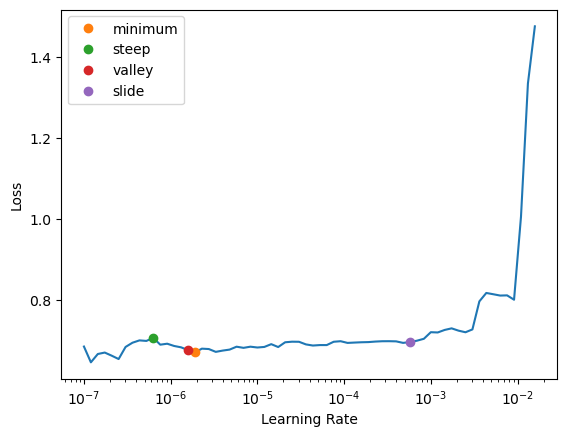

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.687749,0.680575,0.470000,00:21
1,0.263846,0.183117,0.920000,00:23
2,0.172167,0.158182,0.935000,00:21


In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.17216677963733673
valid_loss 0.15818239748477936
accuracy 0.9350000023841858


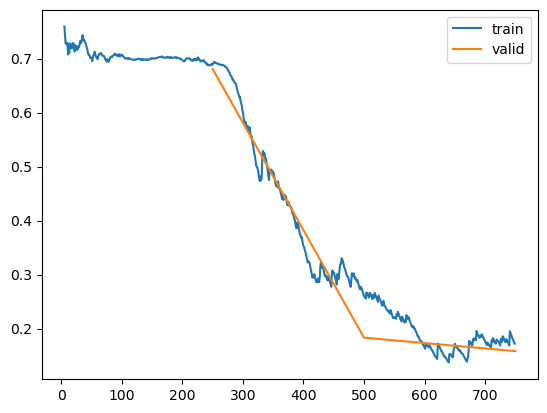

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,text,target,prediction
0,"Once again I must play something of the contrarian. Most of the reviews for Ab Tak Chappan have been extremely positive. Mine is positive, but only slightly. A 7 out of 10 is equivalent to a ""C"" letter grade from me.<br /><br />It seems that a lot of the praise is rooted in two factors: One, that Ab Tak Chappan is more realistic than the typical Bollywood film, and two, that it is trying to do things differently.<br /><br />The first point I couldn't care less about. I'm not looking for realism",pos,neg
1,"The Play Macbeth was written by William Shakespeare between the years of 1604 and 1606. Ever since then, many other versions of the play have been produced, including remakes completed in 1948, 1971, and 2006. Akira Kurosawa even directed a Japanese version of Macbeth in 1957 entitled, ""Kumonosu jô."" The play starts out with King Duncan hearing about the success of two of his generals, Macbeth and Banquo, in a recent battle with the Irish and the Norwegians. After a quick promotion from Duncan,",neg,neg


In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`, and transforms
learn.export("../models/test_text_core_mid_level.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

#### Multilabel

##### Step 1: HF objects.

In [ ]:
# | output: false
hf_arch, hf_config, hf_tokenizer, hf_model = get_new_hf_objects(civil_labels)

=== config ===
# of labels:	7

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


#####  Step 2: `DataBlock`

In [ ]:
tokenize_tfm = BatchTokenizeTransform(hf_arch, hf_config, hf_tokenizer, hf_model)

blocks = (TextBlock(tokenize_tfm=tokenize_tfm), MultiCategoryBlock(encoded=True, vocab=civil_labels))
dblock = DataBlock(blocks=blocks, get_x=ColReader("text"), get_y=ColReader(civil_labels), splitter=ColSplitter())

##### Step 3: `DataLoaders`

In [ ]:
dls = dblock.dataloaders(civil_df, bs=4)

In [ ]:
b = dls.one_batch()
len(b), b[0]["input_ids"].shape, b[1].shape

(2, torch.Size([4, 261]), torch.Size([4, 7]))

In [ ]:
b[0]

{'input_ids': tensor([[     1,    323,    507,  ..., 122816, 122816,      2],
         [     1,    458,    266,  ...,      0,      0,      0],
         [     1,    279,   8665,  ...,      0,      0,      0],
         [     1,    279,   1806,  ...,      0,      0,      0]],
        device='cuda:0'),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0'),
 'labels': TensorMultiCategory([[0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')}

Let's take a look at the actual types represented by our batch

In [ ]:
explode_types(b)

{tuple: [dict, fastai.torch_core.TensorMultiCategory]}

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=500)

,text,target
0,. ✰ ✰ ✰ ✰ ✰ ✰ ▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀ ✰ ✰ ✰ ✰ ✰ ✰ ✰ ✰ ✰ ✰ ✰ ▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄ ✰ ✰ ✰ ✰ ✰ ✰ ✰ ✰ ✰ ✰ ✰ ✰ ✰ ✰ ✰ ✰ ▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄ ✰ ✰ ✰ ✰ ✰ ✰ ✰ ✰ ✰ ✰ ✰ ✰ ✰ ✰ ✰ ✰ ✰ ▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀ ▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄ God bless President Donald J. Trump! God bless America! ▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄,[]
1,"One, I said THIS. """"we ended up with many friends, successes in life"" If you quote me (indicated by the use of quotation marks) then QUOTE ME. I NEVER said ""Saying ""everyone in the past survived to be a happy, successful adult."" Only you did - None killed themselves in my K-12th grade classes & I was in a large city. (My spouse knew of one) I knew of one-yes one-who went to jail for crimes. I knew one who had a baby out of wedlock in my grade and put her up for adoption. One. I also was not in s",[]


##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=BCEWithLogitsLossFlat(),  # PreCalculatedBCELoss()
    metrics=[partial(accuracy_multi, thresh=0.2)],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.loss_func.thresh = 0.15
learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
learn.dls.valid.show_batch(dataloaders=learn.dls, max_n=2, trunc_at=250)

,text,target
0,What is little Justin talking about? This is what Canadians wanted in office... I was also tired of Harper but this guy is ridiculous. Remember little Justin also denied two Canadians 25 years his senior any help at all in the southern PH. He was cal,[]
1,"While there are doubtless supporters of the Communist military dictatorship in Cuba, its also a fact that many of the crowds that show up waving banners, shouting Viva Fidel, are forced to participate. Ive spoken to friends in Cuba from Havana and el",[]


In [ ]:
learn.summary()

BaseModelWrapper (Input shape: 4 x 261)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 261 x 768       
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 261 x 3072      
Linear                         

##### Step 5: Train

SuggestedLRs(minimum=0.0009120108559727668, steep=0.02290867641568184, valley=0.00015848931798245758, slide=0.0020892962347716093)

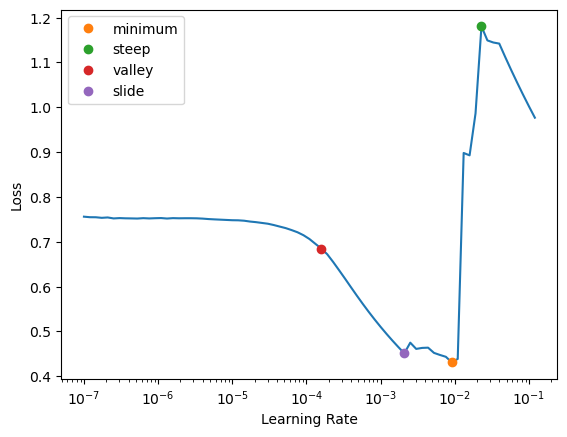

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.170294,0.076894,0.982857,00:17
1,0.069339,0.077017,0.982857,00:18
2,0.057529,0.076109,0.982857,00:18


In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.05752870440483093
valid_loss 0.07610896229743958
accuracy_multi 0.9828571081161499


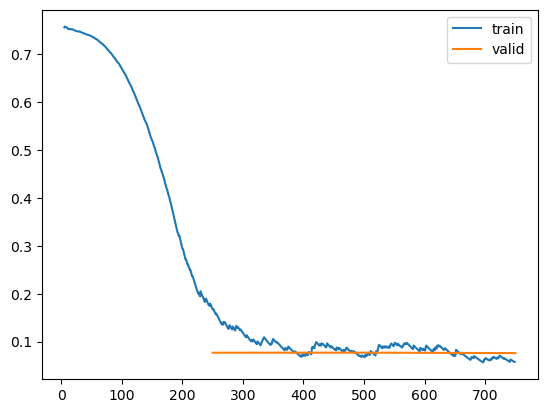

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,text,target,prediction
0,"What is little Justin talking about? This is what Canadians wanted in office... I was also tired of Harper but this guy is ridiculous. Remember little Justin also denied two Canadians 25 years his senior any help at all in the southern PH. He was callous and indifferent to two Canadians about to be beheaded. They were and could have been released for as little as 500k. Who cares? We all should. This boy with a penchant for Mary Jane, movies and video games is as dangerous as Trump being in offic",[],[]
1,"While there are doubtless supporters of the Communist military dictatorship in Cuba, its also a fact that many of the crowds that show up waving banners, shouting Viva Fidel, are forced to participate. Ive spoken to friends in Cuba from Havana and elsewhere. And when the call comes, offices shut down, classes are terminated, everyone has to make signs,and show up. They get a warm coke and a sandwich if they are lucky.But if they dont show up...it can hurt your chances of admission to higher educ",[],[]


In [ ]:
preds, targs, losses = learn.get_preds(with_loss=True)
preds.shape, targs.shape, losses.shape

(torch.Size([200, 7]), torch.Size([200, 7]), torch.Size([200]))

In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`, and transforms
learn.export("../models/test_text_core_mid_level_multilabel.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

## Inference

We need to replace fastai's `Learner.predict` method with the one above which is able to work with inputs that are represented by multiple tensors included in a dictionary.

In [ ]:
# |export
@patch
def blurr_predict(self: Learner, items, rm_type_tfms=None, tok_is_split_into_words=False):
    # grab our blurr tfm with the bits to properly decode/show our inputs/targets
    tfm = first_blurr_tfm(self.dls)
    batch_tok_tfm = get_blurr_tfm(self.dls.before_batch, tfm_class=BatchTokenizeTransform)

    hf_tokenizer = tfm.hf_tokenizer
    trg_labels = tfm.kwargs["labels"] if ("labels" in tfm.kwargs) else None

    is_split_into_words = getattr(tfm, "is_split_into_words", tok_is_split_into_words)
    is_split_str = is_split_into_words == True and isinstance(items[0], str)
    is_df = isinstance(items, pd.DataFrame)

    if not is_df and (is_split_str or not is_listy(items)):
        items = [items]

    # we need to tokenize our items *if* we are not using the mid-level API batch-time tokenization
    if batch_tok_tfm is None:
        inputs_d = dict(
            hf_tokenizer(
                items, is_split_into_words=is_split_into_words, padding=True, max_length=True, truncation=True, return_tensors="pt"
            )
        )
        items = [{k: inputs_d[k][idx] for k in inputs_d.keys()} for idx in range(len(inputs_d["input_ids"]))]

    dl = self.dls.test_dl(items, rm_type_tfms=rm_type_tfms, num_workers=0)

    with self.no_bar():
        probs, _, decoded_preds = self.get_preds(dl=dl, with_input=False, with_decoded=True)

    trg_tfms = self.dls.tfms[self.dls.n_inp :]

    outs = []
    is_multilabel = isinstance(self.loss_func, BCEWithLogitsLossFlat)
    probs, decoded_preds = L(probs), L(decoded_preds)
    for i in range(len(items)):
        item_probs = probs.itemgot(i)
        item_dec_preds = decoded_preds.itemgot(i)
        item_dec_labels = tuplify([tfm.decode(item_dec_preds[tfm_idx]) for tfm_idx, tfm in enumerate(trg_tfms)])[0]

        if trg_labels:
            # handle multiclass output
            if isinstance(item_dec_labels, str) or isinstance(item_dec_labels, int):
                item_dec_labels = [trg_labels[int(item_dec_labels)]]
            elif len(item_dec_labels.size()) == 0:
                item_dec_labels = [item_dec_labels.item()]
            # handle multilabel output
            else:
                item_dec_labels = [trg_labels[lbl_idx] for lbl_idx, lbl in enumerate(item_dec_labels) if lbl == True]

        res = {}
        if is_multilabel:
            res["labels"] = list(item_dec_labels)
            msk = item_dec_preds[0]
            res["scores"] = item_probs[0][msk].tolist()
            res["class_indices"] = [int(val) for val in item_dec_preds[0]]
        else:
            res["label"] = item_dec_labels[0]
            res["score"] = item_probs[0].tolist()[item_dec_preds[0]]
            res["class_index"] = item_dec_preds[0].item()

        if trg_labels is not None or hasattr(self.dls, "vocab"):
            res["class_labels"] = trg_labels if trg_labels else self.dls.vocab
        else:
            res["class_labels"] = None

        res["probs"] = item_probs[0].tolist()

        outs.append(res)
    return outs

In [ ]:
nbdev.show_doc(Learner.blurr_predict)

---

[source](https://github.com/ohmeow/blurr/blob/dev-3.0.0 #master/blurr/text/core.py#L713){target="_blank" style="float:right; font-size:smaller"}

### Learner.blurr_predict

>      Learner.blurr_predict (items, rm_type_tfms=None,
>                             tok_is_split_into_words=False)

### Multiclass

In [ ]:
inf_learn = load_learner("../models/test_text_core_low_level.pkl")

In [ ]:
inf_learn.blurr_predict("This is perhaps the best movie I have ever seen!!!")

[{'label': 1,
  'score': 0.78449547290802,
  'class_index': 1,
  'class_labels': ['neg', 'pos'],
  'probs': [0.2155044674873352, 0.78449547290802]}]

In [ ]:
inf_learn.blurr_predict(["I really liked the movie", "Worse movie I ever saw"])

[{'label': 1,
  'score': 0.8045600056648254,
  'class_index': 1,
  'class_labels': ['neg', 'pos'],
  'probs': [0.19543999433517456, 0.8045600056648254]},
 {'label': 1,
  'score': 0.5400412082672119,
  'class_index': 1,
  'class_labels': ['neg', 'pos'],
  'probs': [0.4599588215351105, 0.5400412082672119]}]

In [ ]:
inf_learn = load_learner("../models/test_text_core_mid_level.pkl")

In [ ]:
inf_learn.blurr_predict("Acting was so bad it was almost funny.")

[{'label': 'neg',
  'score': 0.7812478542327881,
  'class_index': 0,
  'class_labels': ['neg', 'pos'],
  'probs': [0.7812478542327881, 0.2187521755695343]}]

In [ ]:
inf_learn.blurr_predict(["I really liked the movie", "Worse movie I ever saw"])

[{'label': 'pos',
  'score': 0.8790123462677002,
  'class_index': 1,
  'class_labels': ['neg', 'pos'],
  'probs': [0.12098772823810577, 0.8790123462677002]},
 {'label': 'neg',
  'score': 0.6642333269119263,
  'class_index': 0,
  'class_labels': ['neg', 'pos'],
  'probs': [0.6642333269119263, 0.33576664328575134]}]

### Multilabel

In [ ]:
inf_learn = load_learner("../models/test_text_core_low_level_multilabel.pkl")

In [ ]:
inf_learn.blurr_predict("I will tell everyone what you did if you tell you jerk!")

[{'labels': [],
  'scores': [],
  'class_indices': [0, 0, 0, 0, 0, 0, 0],
  'class_labels': ['toxicity',
   'severe_toxicity',
   'obscene',
   'threat',
   'insult',
   'identity_attack',
   'sexual_explicit'],
  'probs': [0.0512266643345356,
   0.001192585565149784,
   0.002417229115962982,
   0.0024306897539645433,
   0.03107926994562149,
   0.005961506627500057,
   0.0021570308599621058]}]

In [ ]:
inf_learn = load_learner("../models/test_text_core_mid_level_multilabel.pkl")

In [ ]:
inf_learn.loss_func.thresh = 0.02


comment = """
Those damned affluent white people should only eat their own food, like cod cakes and boiled potatoes.
No enchiladas for them!
"""
inf_learn.blurr_predict(comment)

[{'labels': ['toxicity', 'insult'],
  'scores': [0.05521469563245773, 0.03640389442443848],
  'class_indices': [1, 0, 0, 0, 1, 0, 0],
  'class_labels': ['toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit'],
  'probs': [0.05521469563245773,
   0.0010418081656098366,
   0.002328298520296812,
   0.00247327727265656,
   0.03640389442443848,
   0.006725737825036049,
   0.002179228700697422]}]

In [ ]:
# |echo:false
try:
    del inf_learn
except:
    pass
finally:
    clean_memory()

## Text Generation

With regards to **text generation**, though not useful in sequence classification, we will also add a `blurr_generate` method to `Learner` that uses Hugging Face's `PreTrainedModel.generate` for text generation tasks.  

For the full list of arguments you can pass in see [here](https://huggingface.co/transformers/main_classes/model.html#transformers.PreTrainedModel.generate). You can also check out their ["How To Generate"](https://github.com/huggingface/blog/blob/master/notebooks/02_how_to_generate.ipynb) notebook for more information about how it all works.

In [ ]:
# |export
@patch
def blurr_generate(self: Learner, items, key="generated_texts", **kwargs):
    """Uses the built-in `generate` method to generate the text
    (see [here](https://huggingface.co/transformers/main_classes/model.html#transformers.PreTrainedModel.generate)
    for a list of arguments you can pass in)
    """
    if not is_listy(items):
        items = [items]

    # grab our blurr tfm with the bits to properly decode/show our inputs/targets
    tfm = first_blurr_tfm(self.dls)

    # grab the Hugging Face tokenizer from the learner's dls.tfms
    hf_tokenizer = tfm.hf_tokenizer
    tok_kwargs = tfm.tok_kwargs

    # grab the text generation kwargs
    text_gen_kwargs = tfm.text_gen_kwargs if (len(kwargs) == 0) else kwargs

    results = []
    for idx, inp in enumerate(items):
        if isinstance(inp, str):
            input_ids = hf_tokenizer.encode(inp, padding=True, truncation=True, return_tensors="pt", **tok_kwargs)
        else:
            # note (10/30/2020): as of pytorch 1.7, this has to be a plain ol tensor (not a subclass of TensorBase)
            input_ids = inp.as_subclass(Tensor)

        input_ids = input_ids.to(self.model.hf_model.device)

        gen_texts = self.model.hf_model.generate(input_ids, **text_gen_kwargs)
        outputs = [hf_tokenizer.decode(txt, skip_special_tokens=True, clean_up_tokenization_spaces=False) for txt in gen_texts]

        if tfm.hf_arch == "pegasus":
            outputs = [o.replace("<n>", " ") for o in outputs]

        results.append({key: outputs[0] if len(outputs) == 1 else outputs})

    return results

In [ ]:
nbdev.show_doc(Learner.blurr_generate)

---

[source](https://github.com/ohmeow/blurr/blob/dev-3.0.0 #master/blurr/text/core.py#L785){target="_blank" style="float:right; font-size:smaller"}

### Learner.blurr_generate

>      Learner.blurr_generate (items, key='generated_texts', **kwargs)

Uses the built-in `generate` method to generate the text
(see [here](https://huggingface.co/transformers/main_classes/model.html#transformers.PreTrainedModel.generate)
for a list of arguments you can pass in)

### Tests

The tests below to ensure the core DataBlock code above works for **all** pretrained sequence classification models available in Hugging Face.  These tests are excluded from the CI workflow because of how long they would take to run and the amount of data that would be required to download.

**Note**: Feel free to modify the code below to test whatever pretrained classification models you are working with ... and if any of your pretrained sequence classification models fail, please submit a github issue *(or a PR if you'd like to fix it yourself)*

## Export -

In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()